# Data Analysis with Python Logs

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import os  
import shutil
import random
from sklearn.metrics import mean_squared_error
import scipy.stats as st 
import tqdm
import pickle
import re
from io import StringIO
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 600
plt.style.use('ggplot')
random.seed(100)

In [2]:
wd = os.getcwd()
path = os.path.join(os.path.join(wd, "data"), "TSV_LOG")

## Function Definitions

### Get All dfs of a Drug

In [3]:
def get_all_drug_dfs(drg, path, wanted_jobs):
    """gets drug dfs and locations of given drug

    Args:
        drg (string): specific drug wanted
        path (string): path to list of TSV's
        wanted_jobs (list): list of jobs to search through

    Returns:
        two lists: list of dfs and list of drug locations
    """
    
    drug_loc = []
    
    # Iterate over every job in the directory 
    for job in os.listdir(path):
        j_path = os.path.join(path, job)
        
        if job in wanted_jobs:
        
            for fold in os.listdir(j_path):
                fold_path = os.path.join(j_path, fold)
                
                inner_most = os.path.join(fold_path, job) 
                # print(f"###{fold}####")
                for num in os.listdir(inner_most):
                    num_path = os.path.join(inner_most, num)
                    tsv_file = os.path.join(num_path, "predicted.tsv")
                    log_file = os.path.join(num_path, "python.log")
    
    
    # for job in os.listdir(path):
    #     curr = os.path.join(path, job)
        
    #     # Check if current job is in the wanted_jobs list 
    #     if job in wanted_jobs:
    #         print(f"----------{job}----------")
    #         samples_rmse_curr = {}
            
    #         # Iterates over every model in the job
    #         for model in tqdm.tqdm(os.listdir(curr)):
    #             inner = os.path.join(curr, model)
                
    #             # Iterates over every file within the model 
    #             for subdir, dirs, files in os.walk(inner):
    #                 for file in files:
                        
                        # Creates dataframe
                    # f = os.path.join(subdir, file)
                    df = pd.read_csv(tsv_file, sep="\t")
                    
                    # Gets drug
                    drug = df["Drug1"][0]
                    fold_num = fold
                    number = num
                    # Checks to see if drug is the same as wanted drug
                    if drg == drug:
                        drug_loc.append((job, fold_num, number))

    dfs = []
    locs = []
    
    # Iterates over all the found locations of the drg TSVs
    for j,folder, number in drug_loc:
        
        file = os.path.join(os.path.join(os.path.join(os.path.join(os.path.join(path, j), folder), j), number), "predicted.tsv")

        # Make a dataframe and include a new column with what job it is from
        df = pd.read_csv(file, sep="\t")
        df["Job"] = j
        
        locs.append((j,folder))
        dfs.append(df)

    return dfs, locs

### Get Combined Dataframes of All Drugs into a Dictionary

In [4]:
def get_data_ALL(path, wanted_jobs):
    """Get all drug data into one dictionary from all specified jobs

    Args:
        path (string): path to list of tsv's
        wanted_jobs (list): list of jobs to look through

    Returns:
        dictonary: dictionary indexed by drug name
    """
    drugs_perf = {}

    for job in os.listdir(path):
        j_path = os.path.join(path, job)
        
        if job in wanted_jobs:
        
            for fold in os.listdir(j_path):
                fold_path = os.path.join(j_path, fold)
                
                inner_most = os.path.join(fold_path, job) 
                # print(f"###{fold}####")
                for num in os.listdir(inner_most):
                    num_path = os.path.join(inner_most, num)
                    tsv_file = os.path.join(num_path, "predicted.tsv")
                    log_file = os.path.join(num_path, "python.log")
            # if job in wanted_jobs:    
            #     for model in tqdm.tqdm(os.listdir(curr), desc=f"{job}"):
            #         inner = os.path.join(curr, model)
                    
            #         for subdir, dirs, files in os.walk(inner):
            #             for file in files:
                            # f = os.path.join(subdir, file)
                    df = pd.read_csv(tsv_file, sep="\t")
                    # print(df.columns)
                    
                    drug = df["Drug1"][0]
                    
                    if drug not in drugs_perf:
                        drugs_perf[drug] = []
                        drugs_perf[drug].append(df)
                    else:
                        drugs_perf[drug].append(df)
                        
    
    drug_dict = {}
    for key, value in tqdm.tqdm(drugs_perf.items()):
        drug_dict[key] = pd.concat(value)
        
        
    return drug_dict

### Make a Multiplot of Distribution of Drug in Specified Jobs

In [5]:
def make_multiplot(drg, path, wanted_jobs):
    
    drug_dfs, drug_jobs = get_all_drug_dfs(drg=drg, path=path, wanted_jobs=wanted_jobs)
    
    # print(drug_dfs)
    
    # Get grid layout
    N = len(drug_dfs)
    x=np.floor(np.sqrt(N))
    y=np.ceil(N/x)
    
    # print(f"TOTAL: {N}-----({x, y})")
    
    # Make Subplots
    fig, ax1 = plt.subplots(int(x), int(y), squeeze=False)
    fig.subplots_adjust(hspace=0.4, wspace = 0.45)
    fig.suptitle(f"Distribution of {drg} over all Individual Jobs")
    
    k = 0
    j = 0

    # Iterate over all subplots and plot each distribution for every specified job
    for i, d in enumerate(drug_dfs):
        # print(f"####### {(k,j)} #######")
        # print(d["AUCError"])

        k = int(k)
        j = int(j)
        d["AUCError"].plot.kde(ax=ax1[k][j] )
        d["AUCError"].plot.hist(ax=ax1[k][j],density = False, bins=30, rwidth = 0.9, xlim = (-1, 1))

        ax1[k][j].set_title(f"{drug_jobs[i][0]}", size = 7)
        ax1[k][j].set_ylabel("Frequency",size = 4 )
        ax1[k][j].set_xlabel("AUC Error", size = 4)
        
        k += 1
        k = k % x
        if k == 0:
            j += 1
        j = j % y

### Overlay normal pdf ontop of drug histogram

In [6]:
def norm_hist(data):
    mu, std = st.norm.fit(data)
    # Plot the histogram.
    plt.hist(data, bins=30, density=True, alpha=0.6, color='b')
    
    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = st.norm.pdf(x, mu, std)
    
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
    plt.title(title)
    
    plt.show()

In [7]:
# drug_dict = get_data_ALL(path=path, wanted_jobs=["9000896.amn-0001"])

In [8]:
# make_multiplot("Drug_988", path=path, wanted_jobs=["9000896.amn-0001"])

### Make A distribution Plot of a given Drug

In [9]:
def make_distrib_plot(drg, d_dict):
    
    # Get dataframe for specified drug
    drug_df = d_dict[drg]
    
    # Plot Distribution 
    fig, ax1 = plt.subplots()
    
    drug_df["AUCError"].plot.kde(ax=ax1, 
                            grid = True, )
    drug_df["AUCError"].plot.hist(ax=ax1,
                            density = True, 
                            bins=30, 
                            rwidth = 0.9)

    ax1.set_title(f"Distribution of AUC Errors of {drg}\nAll Specified Jobs")
    ax1.set_ylabel("")
    ax1.set_xlabel("AUC Error")

In [10]:
# make_distrib_plot("Drug_988", drug_dict)

### Bootstrap RMSE

In [11]:
def boostraped_rmse(df, B): 
    """Create Bootsrtap sample of a statistic

    Args:
        x (num): values you want infrence from 
        B (in): Number of bootstrap samples
        statsFun (fun): metric you want infrence on 
    """
    x_auc = df["AUC"]
    x_pred_auc = df["PredictedAUC"]
    x_auc = np.array(x_auc)
    x_pred_auc = np.array(x_pred_auc)
    
    resampled_stat = []
    
    for b in tqdm.tqdm(range(B)):
        index = np.random.randint(0, len(x_auc), len(x_auc))
        sample_auc = x_auc[index]
        sample_pred_auc = x_pred_auc[index]
        
        bstatistic = mean_squared_error(sample_auc, sample_pred_auc, squared=False)
        resampled_stat.append(bstatistic)
        
    return np.array(resampled_stat)

In [12]:
# job = "9000896.amn-0001"
# folder = "x1922c5s2b0n0"
# num = "0"
# tsv = "predicted.tsv"
# log = "python.log"

# tsv_file = os.path.join(path, os.path.join(job, os.path.join(folder, os.path.join(job, os.path.join(num, tsv)))))
# log_file = os.path.join(path, os.path.join(job, os.path.join(folder, os.path.join(job, os.path.join(num, log)))))

# (tsv_file, log_file)

## Parsing Log Files

### Getting Specified Epochs and Actual epochs ran

In [13]:


# key_list = ["Job", "Folder", "Num", "epochs_wanted", "actual_epochs"]
# data = {key: [] for key in key_list}

# data["Job"].append(job)
# data["Folder"].append(folder)
# data["Num"].append(num)
# print(data)

# log_data = open(log_file, 'r')
# for line in log_data:

#     # Get specified epochs
#     matches_wanted = re.findall("'epochs': \d+", line)
    
#     # get how many epochs it actually ran for
#     matches_history = re.findall("history_length: \d+", line)

#     if matches_wanted:
#         data["epochs_wanted"].append(matches_wanted[0][-2:]) 
#         print(matches_wanted[0][-2:])

#     if matches_history:
#         data["actual_epochs"].append(matches_history[0][-2:])
#         print(matches_history[0][-2:])


In [14]:
key_list = ["Job", "Folder", "Num", "drug", "epochs_wanted", "actual_epochs"]
data = {key: [] for key in key_list}

for j in os.listdir(path):
    # print(f"-------------{j}-------------")
    j_path = os.path.join(path, j)
    for fold in os.listdir(j_path):
        fold_path = os.path.join(j_path, fold)
        
        inner_most = os.path.join(fold_path, j) 
        # print(f"###{fold}####")
        for num in os.listdir(inner_most):
            num_path = os.path.join(inner_most, num)
            tsv_file = os.path.join(num_path, "predicted.tsv")
            log_file = os.path.join(num_path, "python.log")
            
            if os.path.exists(tsv_file):
                df = pd.read_csv(tsv_file, sep="\t")
                
                drug = df["Drug1"][0]
                
                data["Job"].append(j)
                data["Folder"].append(fold)
                data["drug"].append(drug)
                data["Num"].append(num)
                prev_epoch_hist_length = len(data["actual_epochs"])
                log_data = open(log_file, 'r')
                # data["path"].append(tsv_file)
                for line in log_data:

                    # Get specified epochs
                    matches_wanted = re.findall("'epochs': \d+", line)
                    
                    # get how many epochs it actually ran for
                    matches_history = re.findall("history_length: \d+", line)

                    if matches_wanted:
                        data["epochs_wanted"].append(matches_wanted[0][-2:]) 
                        # print(matches_wanted[0])
                    # else:
                    #     print("fjdashfkjsahdfhdajkshfkashfjsakhfdkajs")

                    if matches_history:
                        data["actual_epochs"].append(matches_history[0][-2:])
                        # print(matches_history[0])
                        
                    # else:
                    #     print("fjdashfkjsahdfhdajkshfkashfjsakhfdkajs")
                # if len(data["actual_epochs"]) == prev_epoch_hist_length:
                #     print(f"{j}: {num}")
                #     print(log_file)
                #     print("fdjhfajkhfjbhbhjgbhjghjgjgjhgjhgjhguhuivibkdhajahk")
            else:
                print(f"{j}/{fold}/{j}/{num}")
                
                # prev_epoch_hist_length = len(data["actual_epochs"])
    

9002852.amn-0001/x1921c0s6b0n0/9002852.amn-0001/20
9002852.amn-0001/x1921c0s6b0n0/9002852.amn-0001/0
9002852.amn-0001/x1921c0s6b0n0/9002852.amn-0001/11
9002852.amn-0001/x1921c0s6b0n0/9002852.amn-0001/7
9002852.amn-0001/x1921c0s6b0n0/9002852.amn-0001/16
9002852.amn-0001/x1921c0s6b0n0/9002852.amn-0001/6
9002852.amn-0001/x1921c0s6b0n0/9002852.amn-0001/10
9002852.amn-0001/x1921c0s6b0n0/9002852.amn-0001/21
9002852.amn-0001/x1921c0s6b0n0/9002852.amn-0001/15
9002852.amn-0001/x1921c0s6b0n0/9002852.amn-0001/13
9002852.amn-0001/x1921c0s6b0n0/9002852.amn-0001/5
9002852.amn-0001/x1921c0s6b0n0/9002852.amn-0001/14


In [15]:
for key, val in data.items():
    print((f"{key}: {len(val)}"))

Job: 1896
Folder: 1896
Num: 1896
drug: 1896
epochs_wanted: 1896
actual_epochs: 1896


In [16]:
df = pd.DataFrame(data)
df[["epochs_wanted", "actual_epochs"]] = df[["epochs_wanted", "actual_epochs"]].apply(pd.to_numeric)


In [17]:
df = (df.assign(
        epoch_diff =df["epochs_wanted"] - df["actual_epochs"]
    )
)
# print(len(df.index))
print(df.sort_values(["epochs_wanted", "actual_epochs"], ascending=[False, True]).to_string())

                   Job         Folder  Num       drug  epochs_wanted  actual_epochs  epoch_diff
1379  8999163.amn-0001  x1922c5s0b0n0   85  Drug_1390             75             27          48
1411  8999163.amn-0001  x1922c5s2b0n0   98  Drug_1214             75             28          47
578   8997987.amn-0001  x1921c1s1b0n0   11   Drug_515             75             29          46
668   8999189.amn-0001  x1922c6s3b0n0  139     Drug_8             75             29          46
596   8997987.amn-0001  x1921c1s2b0n0   12    Drug_13             75             30          45
1333  8999163.amn-0001  x1922c6s2b0n0  132   Drug_396             75             30          45
1438  8999163.amn-0001  x1922c3s0b0n0   14   Drug_563             75             30          45
577   8997987.amn-0001  x1921c1s1b0n0    0   Drug_632             75             31          44
607   8999189.amn-0001  x1922c6s1b0n0  108   Drug_703             75             31          44
638   8999189.amn-0001  x1922c2s6b0n0   

In [18]:
# df.groupby("Job").agg({"epochs_wanted": "mean"})
df.sort_values("epoch_diff")

,Job,Folder,Num,drug,epochs_wanted,actual_epochs,epoch_diff
0,8998707.amn-0001,x1922c3s3b0n0,20,Drug_1356,2,2,0
1468,8998639.amn-0001,x1921c3s2b0n0,19,Drug_1123,2,2,0
1469,8998639.amn-0001,x1921c3s2b0n0,21,Drug_1052,2,2,0
1470,8998639.amn-0001,x1921c3s2b0n0,23,Drug_1327,2,2,0
1471,8998639.amn-0001,x1921c3s2b0n0,15,Drug_172,2,2,0
...,...,...,...,...,...,...,...
596,8997987.amn-0001,x1921c1s2b0n0,12,Drug_13,75,30,45
668,8999189.amn-0001,x1922c6s3b0n0,139,Drug_8,75,29,46
578,8997987.amn-0001,x1921c1s1b0n0,11,Drug_515,75,29,46
1411,8999163.amn-0001,x1922c5s2b0n0,98,Drug_1214,75,28,47


In [19]:
df_75 = df[df["epochs_wanted"] == 75]
jobs_75 = df_75["Job"].unique()
drugs_75 = df_75["drug"].unique()
jobs_75

array(['8997987.amn-0001', '8999189.amn-0001', '8998722.amn-0001',
       '8999163.amn-0001'], dtype=object)

In [20]:
all_dict = get_data_ALL(path=path, wanted_jobs=jobs_75)
# all_dict[drugs_75]

100%|██████████| 144/144 [00:00<00:00, 2490.49it/s]


Text(0, 0.5, 'Frequency')

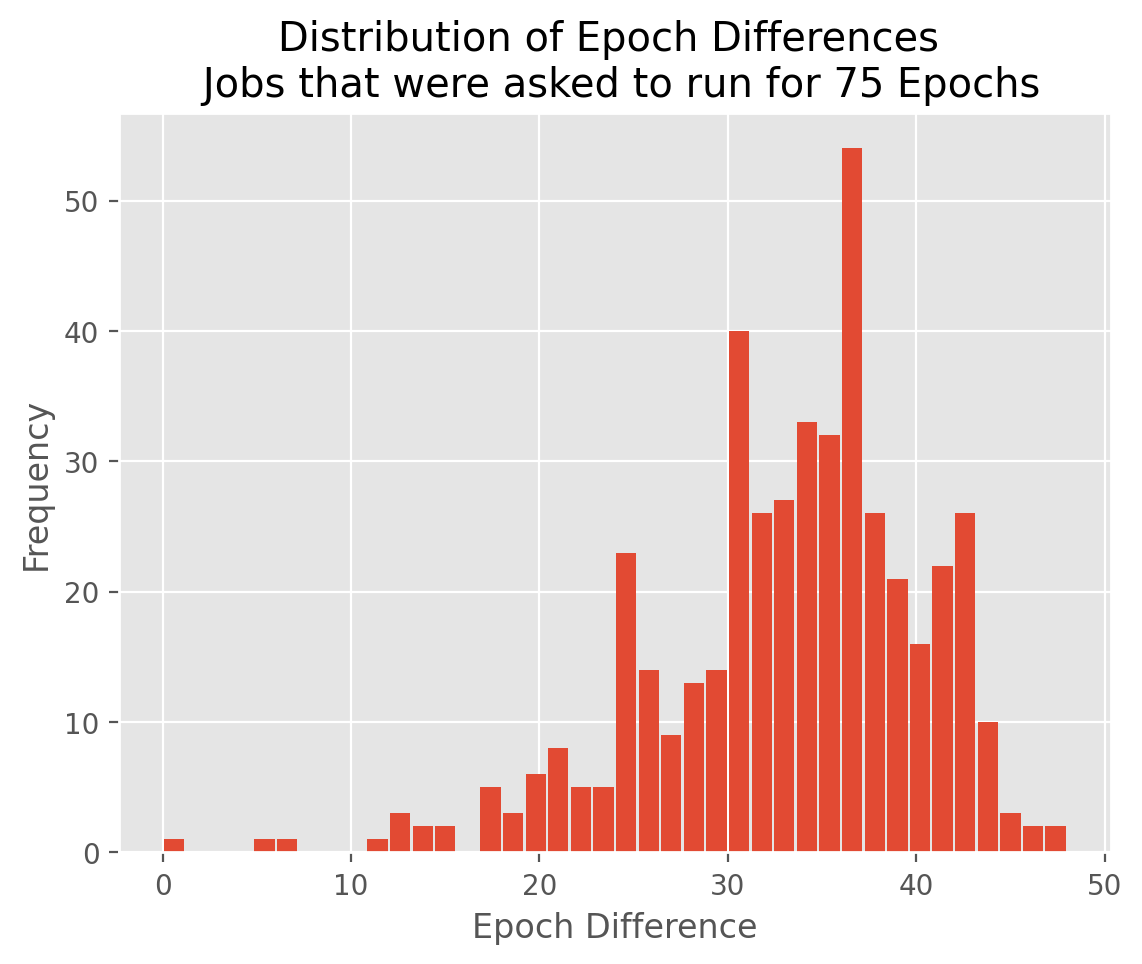

In [21]:
fig, ax = plt.subplots()

ax.hist(df_75["epoch_diff"], bins=40, rwidth=0.9)
ax.set_title("Distribution of Epoch Differences \n Jobs that were asked to run for 75 Epochs")
ax.set_xlabel("Epoch Difference")
ax.set_ylabel("Frequency")

In [22]:


gb = df_75.groupby("drug")
counts = gb.size().to_frame(name="counts")
srted = (counts
    .join(gb.agg({'epoch_diff': 'mean'}).rename(columns={'epoch_diff': 'epoch_diff_mean'}))
    # .join(gb.agg({'epochs_wanted': 'mean'}).rename(columns={'epochs_wanted': 'epochs_wanted_mean'}))
    .reset_index()
    .sort_values(["epoch_diff_mean", "counts"], ascending=False)
)

Text(0.5, 1.0, 'Mean Epoch Diffs per Drug\n Jobs: 75')

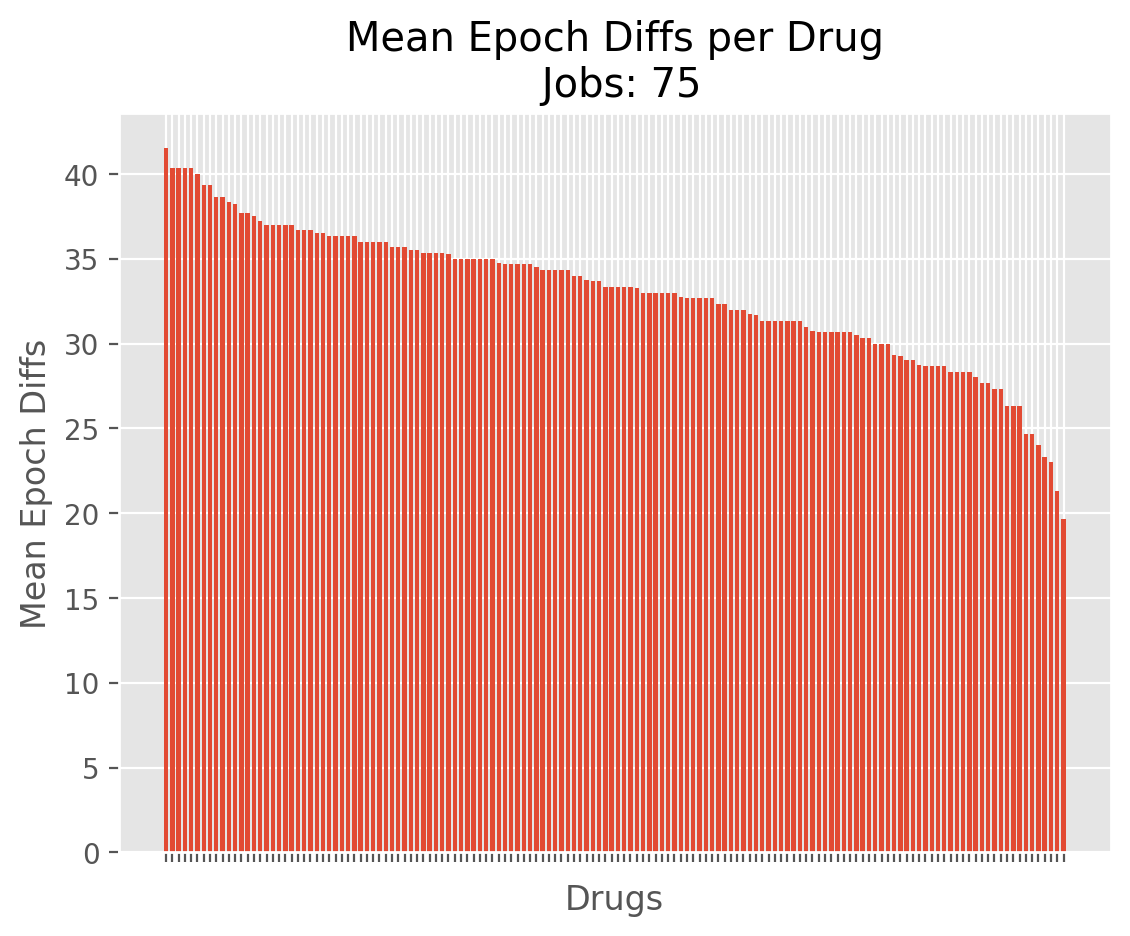

In [23]:
fig, ax = plt.subplots()

ax.bar(x = pd.Categorical(srted["drug"]), height=srted["epoch_diff_mean"], width=0.7)
ax.set_xticklabels([])

ax.set_ylabel("Mean Epoch Diffs")
ax.set_xlabel("Drugs")
ax.set_title("Mean Epoch Diffs per Drug\n Jobs: 75")

In [24]:

dict_75 = {}
for key in drugs_75:
    dict_75[key] = all_dict[key]

In [25]:
dict_75

{'Drug_76':         AUC      Sample    Drug1  PredictedAUC  AUCError
 0    0.9663  ACH-000001  Drug_76        0.9733  0.007003
 1    0.9818  ACH-000002  Drug_76        0.9910  0.009242
 2    0.9894  ACH-000004  Drug_76        0.9784 -0.010990
 3    0.9452  ACH-000006  Drug_76        0.9721  0.026860
 4    0.9968  ACH-000007  Drug_76        0.9769 -0.019880
 ..      ...         ...      ...           ...       ...
 540  0.9433  ACH-001106  Drug_76        0.9907  0.047350
 541  0.9963  ACH-001190  Drug_76        1.0060  0.009939
 542  0.9772  ACH-001306  Drug_76        0.9840  0.006751
 543  0.9545  ACH-001307  Drug_76        0.9814  0.026890
 544  0.9865  ACH-001321  Drug_76        0.9814 -0.005126
 
 [2180 rows x 5 columns],
 'Drug_632':          AUC      Sample     Drug1  PredictedAUC  AUCError
 0     0.8665  ACH-000001  Drug_632        0.9463  0.079800
 1     0.9553  ACH-000001  Drug_632        0.9466 -0.008671
 2     0.3982  ACH-000002  Drug_632        0.6274  0.229200
 3     0.4611

In [26]:
print(len(jobs_75))
jobs_75

4


array(['8997987.amn-0001', '8999189.amn-0001', '8998722.amn-0001',
       '8999163.amn-0001'], dtype=object)

In [27]:
key_list = ["Drug", "RMSE", "n"]
drug_perf_75 = {key: [] for key in key_list}
for key in dict_75.keys():
    # make_distrib_plot(key, dict_75)
    n = len(dict_75[key].index)
    rmse = mean_squared_error(dict_75[key]["AUC"], dict_75[key]["PredictedAUC"])
    drug_perf_75["Drug"].append(key)
    drug_perf_75["RMSE"].append(rmse)
    drug_perf_75["n"].append(n)
    
pd.DataFrame(drug_perf_75).sort_values("RMSE", ascending=False).head(50)

,Drug,RMSE,n
5,Drug_988,0.227390,7604
24,Drug_1079,0.196181,2124
98,Drug_736,0.187986,1647
135,Drug_1218,0.149860,3303
12,Drug_620,0.082365,2700
11,Drug_1062,0.081866,2308
114,Drug_1036,0.077726,4017
70,Drug_1327,0.067661,5340
37,Drug_946,0.067019,1698
104,Drug_1219,0.062255,2109


In [28]:
for key in dict_75.keys():
     dfs, j= get_all_drug_dfs(key, path=path, wanted_jobs=jobs_75)
     print(f"Drug: {key}---dfs: {len(dfs)}")

Drug: Drug_76---dfs: 4
Drug: Drug_632---dfs: 4
Drug: Drug_515---dfs: 4
Drug: Drug_508---dfs: 4
Drug: Drug_246---dfs: 4
Drug: Drug_988---dfs: 4
Drug: Drug_1064---dfs: 4
Drug: Drug_1005---dfs: 4
Drug: Drug_1507---dfs: 4
Drug: Drug_303---dfs: 4
Drug: Drug_457---dfs: 4
Drug: Drug_1062---dfs: 4
Drug: Drug_620---dfs: 4
Drug: Drug_1335---dfs: 4
Drug: Drug_109---dfs: 4
Drug: Drug_501---dfs: 4
Drug: Drug_93---dfs: 4
Drug: Drug_1444---dfs: 4
Drug: Drug_980---dfs: 4
Drug: Drug_1102---dfs: 4
Drug: Drug_13---dfs: 4
Drug: Drug_563---dfs: 4
Drug: Drug_1494---dfs: 4
Drug: Drug_953---dfs: 4
Drug: Drug_1079---dfs: 3
Drug: Drug_331---dfs: 3
Drug: Drug_1391---dfs: 3
Drug: Drug_146---dfs: 3
Drug: Drug_1236---dfs: 3
Drug: Drug_308---dfs: 3
Drug: Drug_294---dfs: 3
Drug: Drug_703---dfs: 3
Drug: Drug_335---dfs: 3
Drug: Drug_1371---dfs: 3
Drug: Drug_398---dfs: 3
Drug: Drug_1434---dfs: 3
Drug: Drug_31---dfs: 3
Drug: Drug_946---dfs: 3
Drug: Drug_1171---dfs: 3
Drug: Drug_360---dfs: 3
Drug: Drug_18---dfs: 3
Drug: D

## Drug 988 Investigation

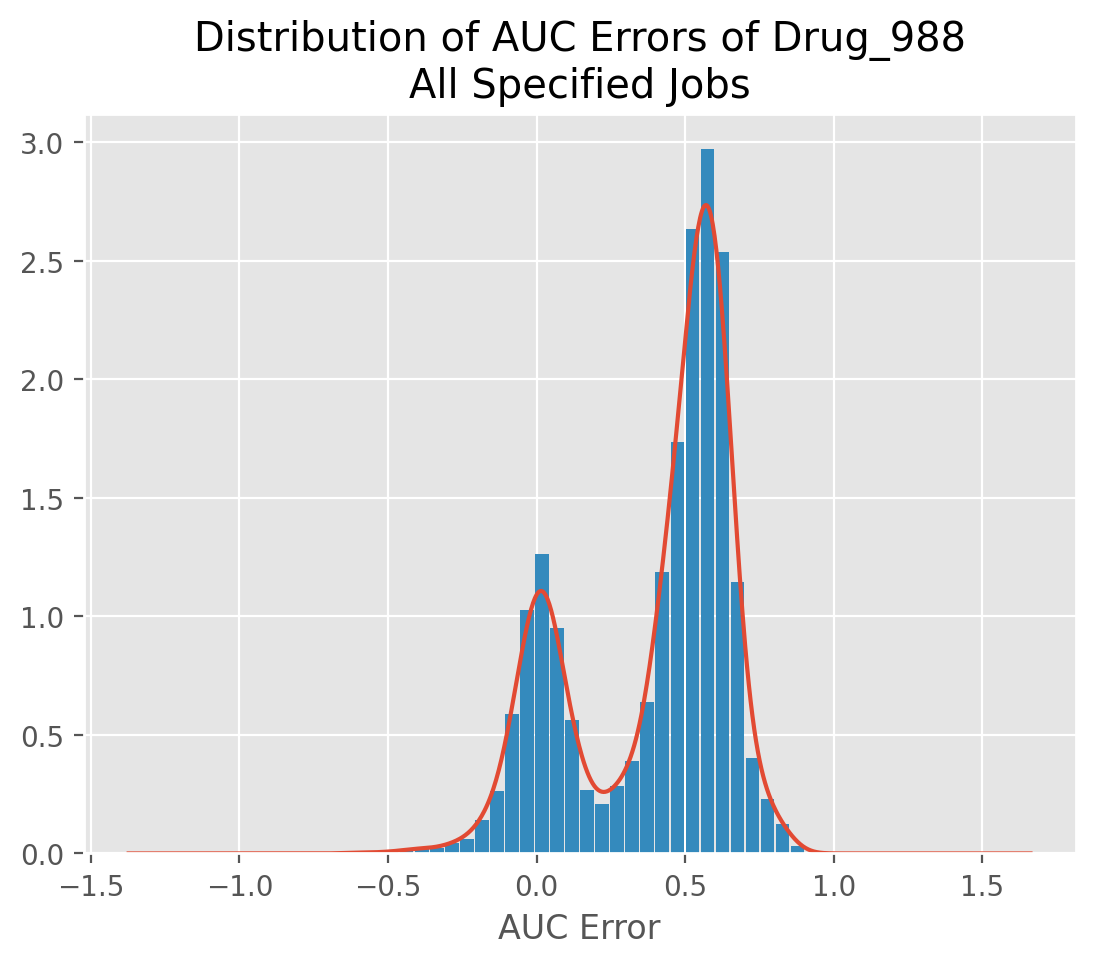

In [29]:
make_distrib_plot("Drug_988", dict_75)

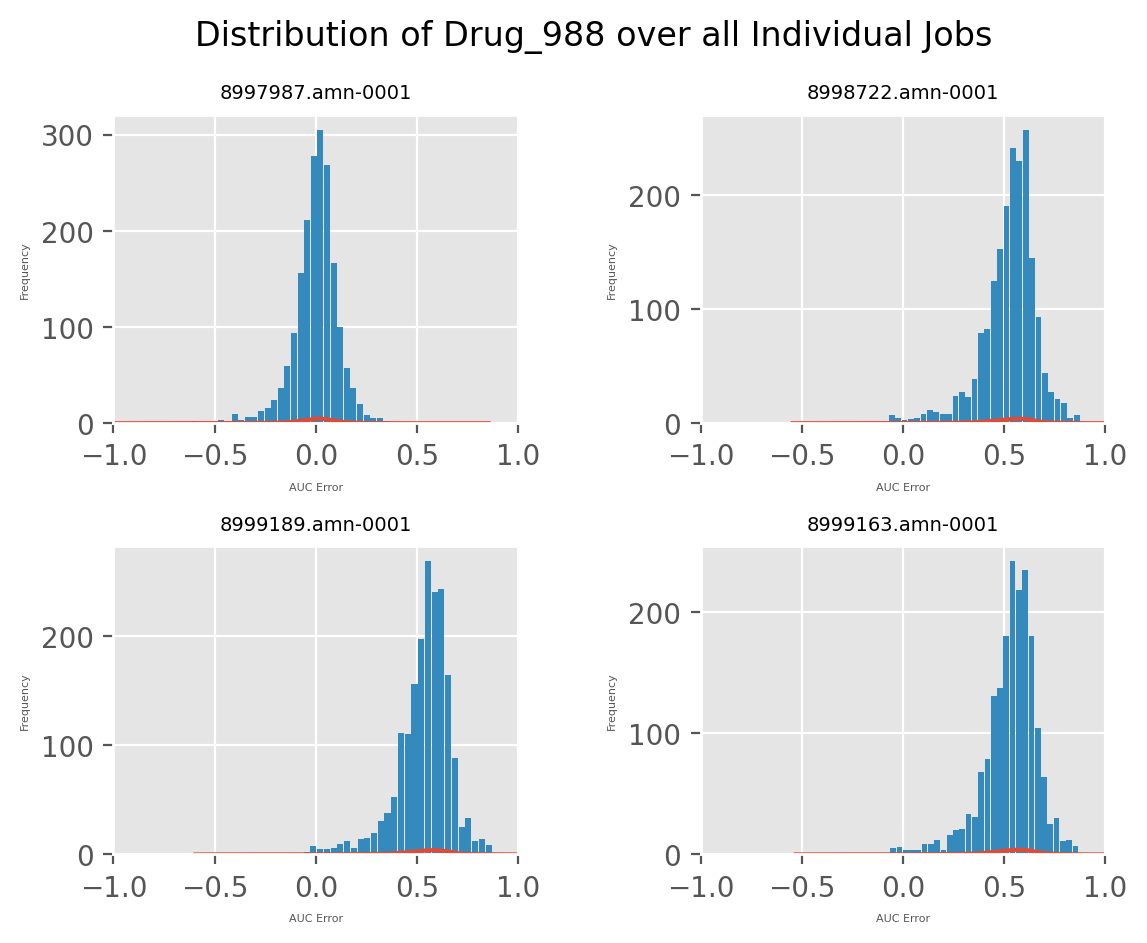

In [30]:
make_multiplot("Drug_988", path=path, wanted_jobs=jobs_75)

## Drug 736

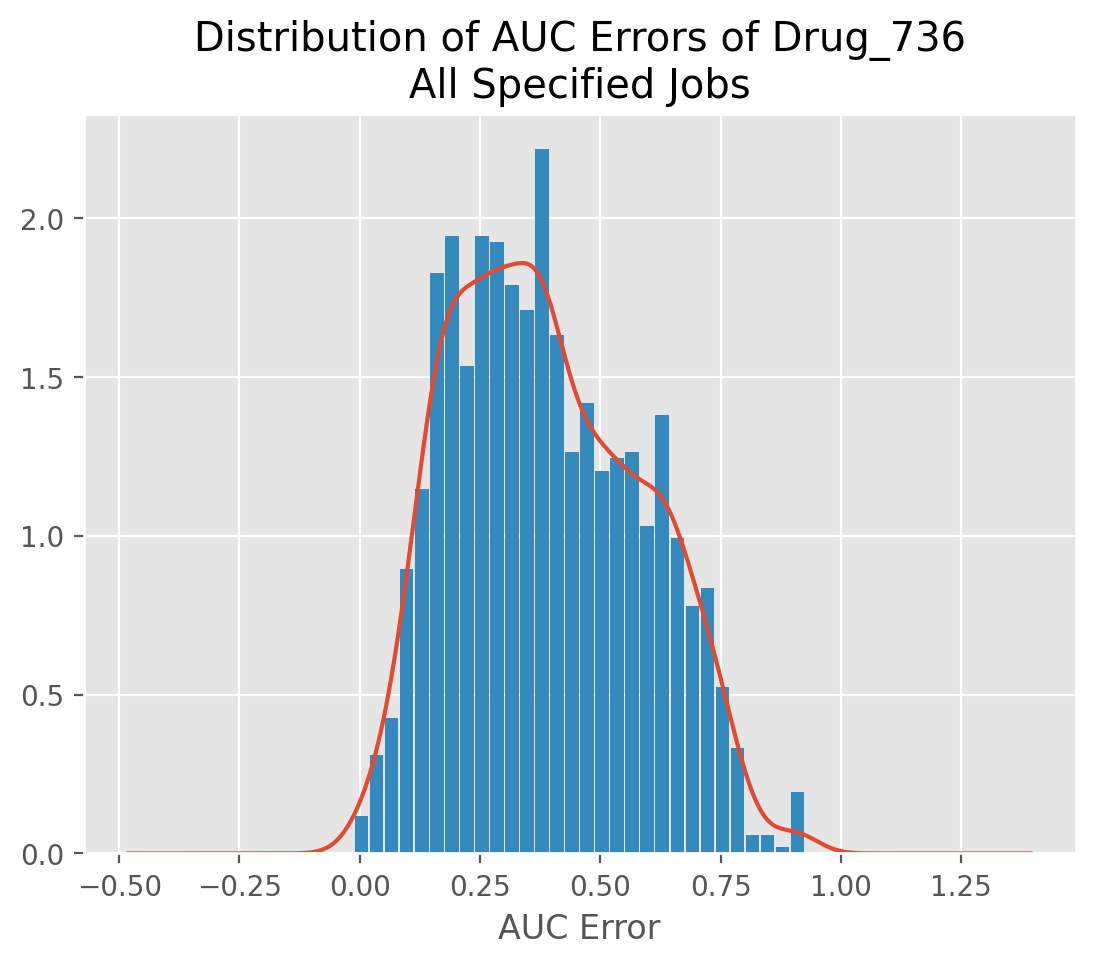

In [31]:
make_distrib_plot("Drug_736", dict_75)

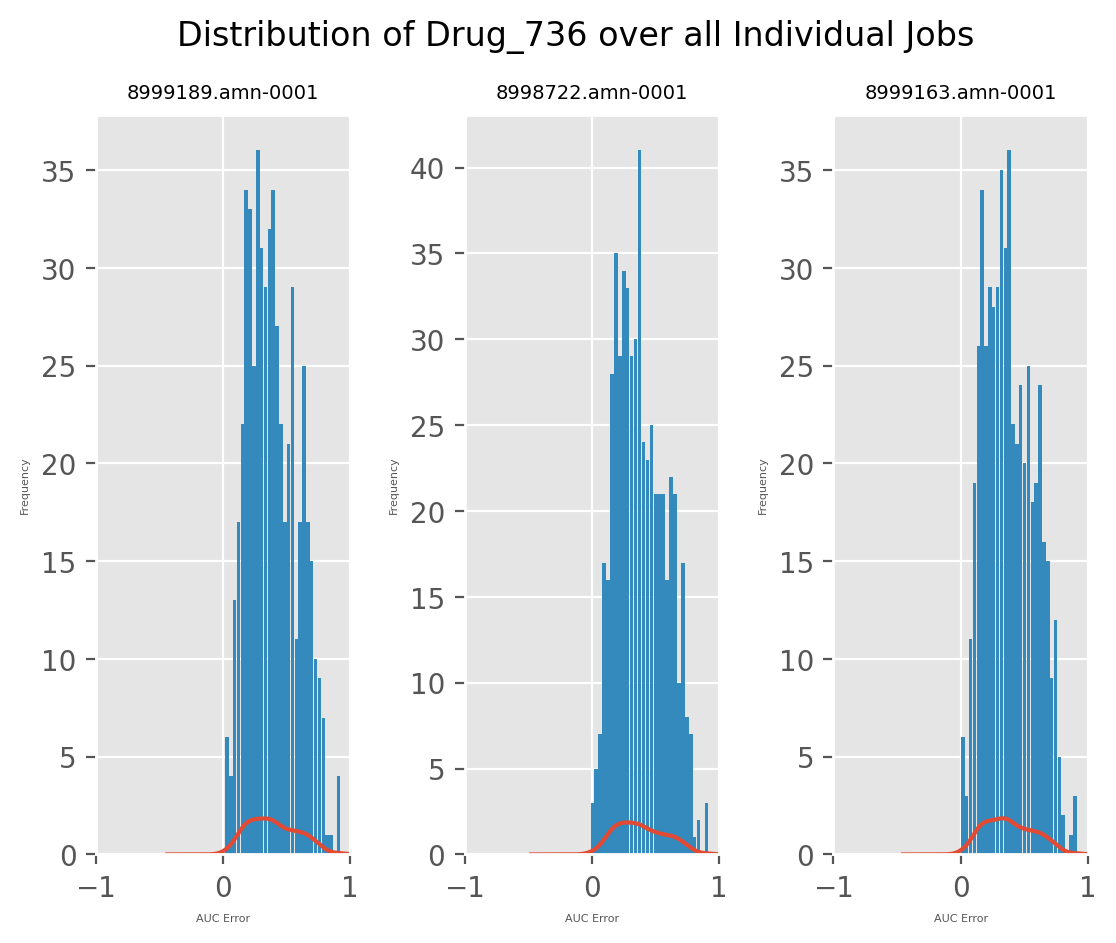

In [32]:
make_multiplot("Drug_736", path=path, wanted_jobs=jobs_75)

In [33]:
boot_736 = boostraped_rmse(dict_75["Drug_736"], 100000)

100%|██████████| 100000/100000 [00:07<00:00, 13166.71it/s]


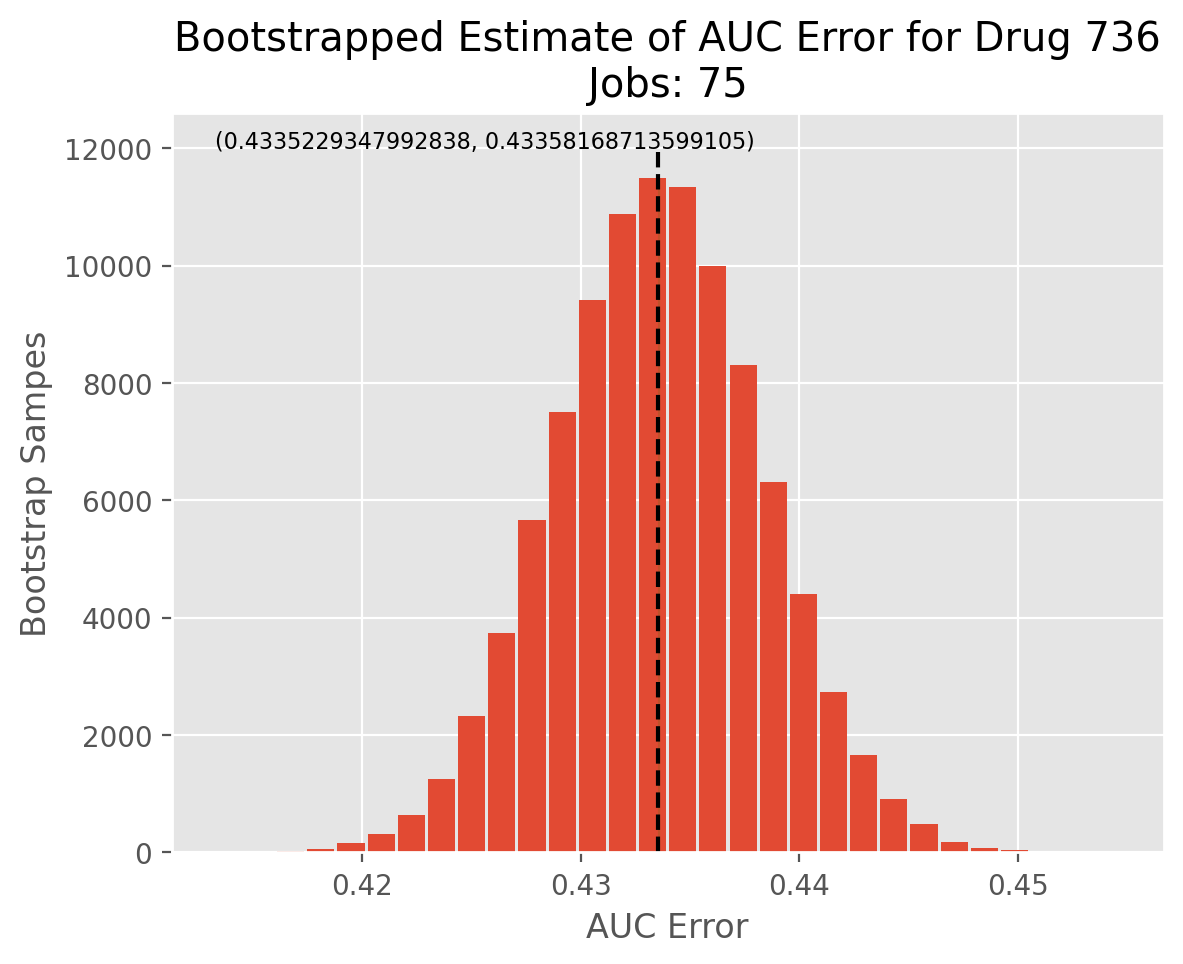

In [34]:
fig, ax = plt.subplots()
confint = st.t.interval(confidence = 0.95, 
                        df = len(boot_736)-1, 
                        loc = np.mean(boot_736), 
                        scale = st.sem(boot_736) )

heights, bins, patches = ax.hist(boot_736, bins=30, rwidth=0.9)
ax.vlines(x = np.mean(boot_736), 
          ymin = 0, 
          ymax=12000, 
          colors="black", 
          linestyles="dashed")

ax.set_title(f"Bootstrapped Estimate of AUC Error for Drug 736\nJobs: 75")
ax.set_ylabel("Bootstrap Sampes")
ax.set_xlabel("AUC Error")
ax.text(x = min(boot_736), y = 12000, s = confint, size = 8)
ax.fill_betweenx([0, heights.max()],confint[0], confint[1], alpha = 0.1, color = "g")

## Drug 1218

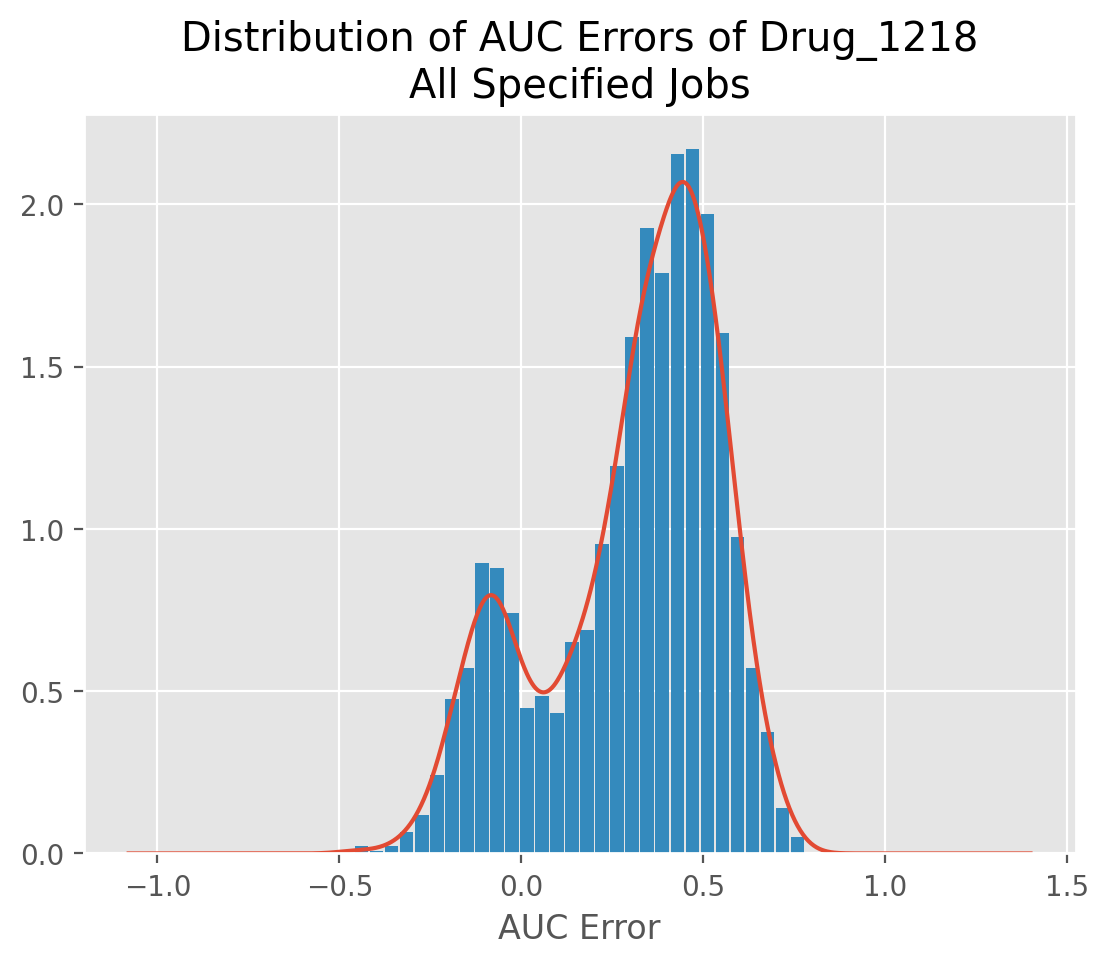

In [35]:
make_distrib_plot("Drug_1218", dict_75)

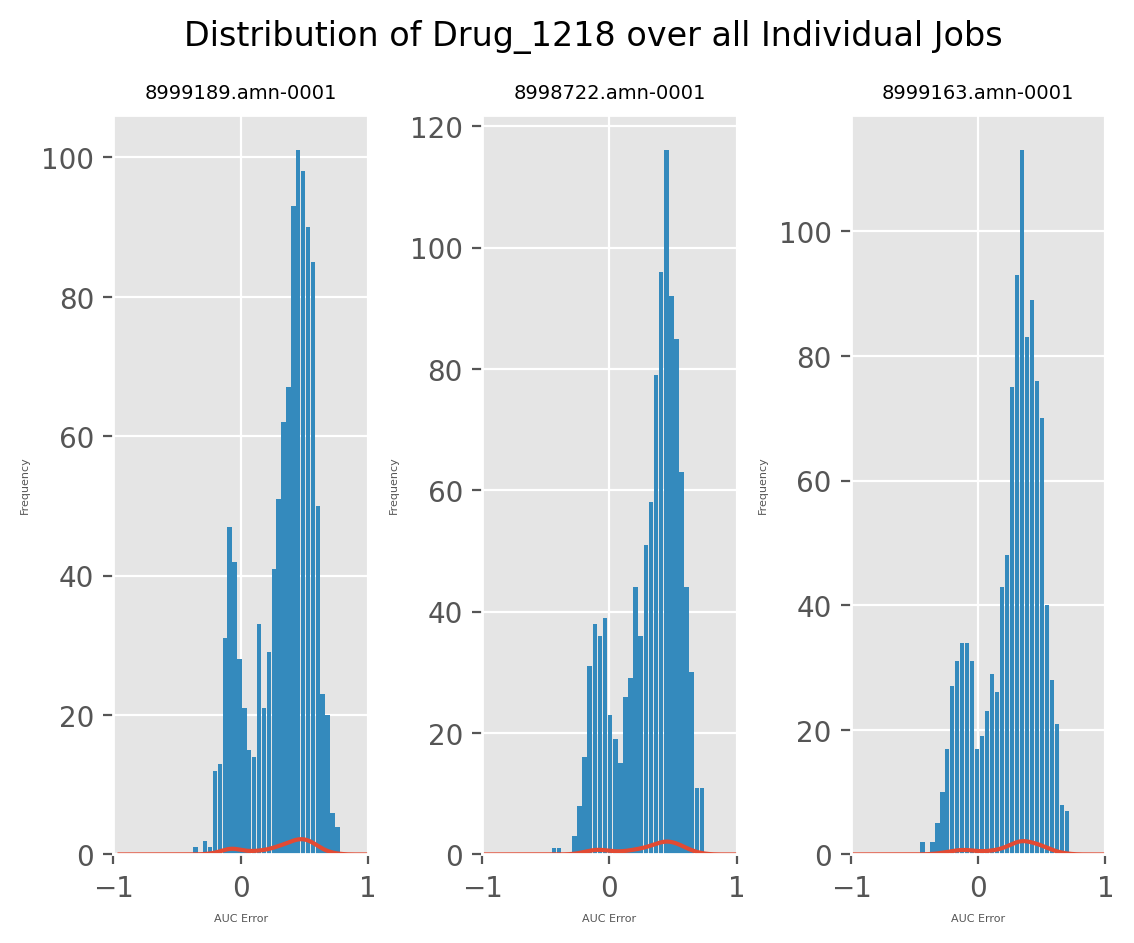

In [55]:
make_multiplot("Drug_1218", path=path, wanted_jobs=jobs_75)

## Drug 1079

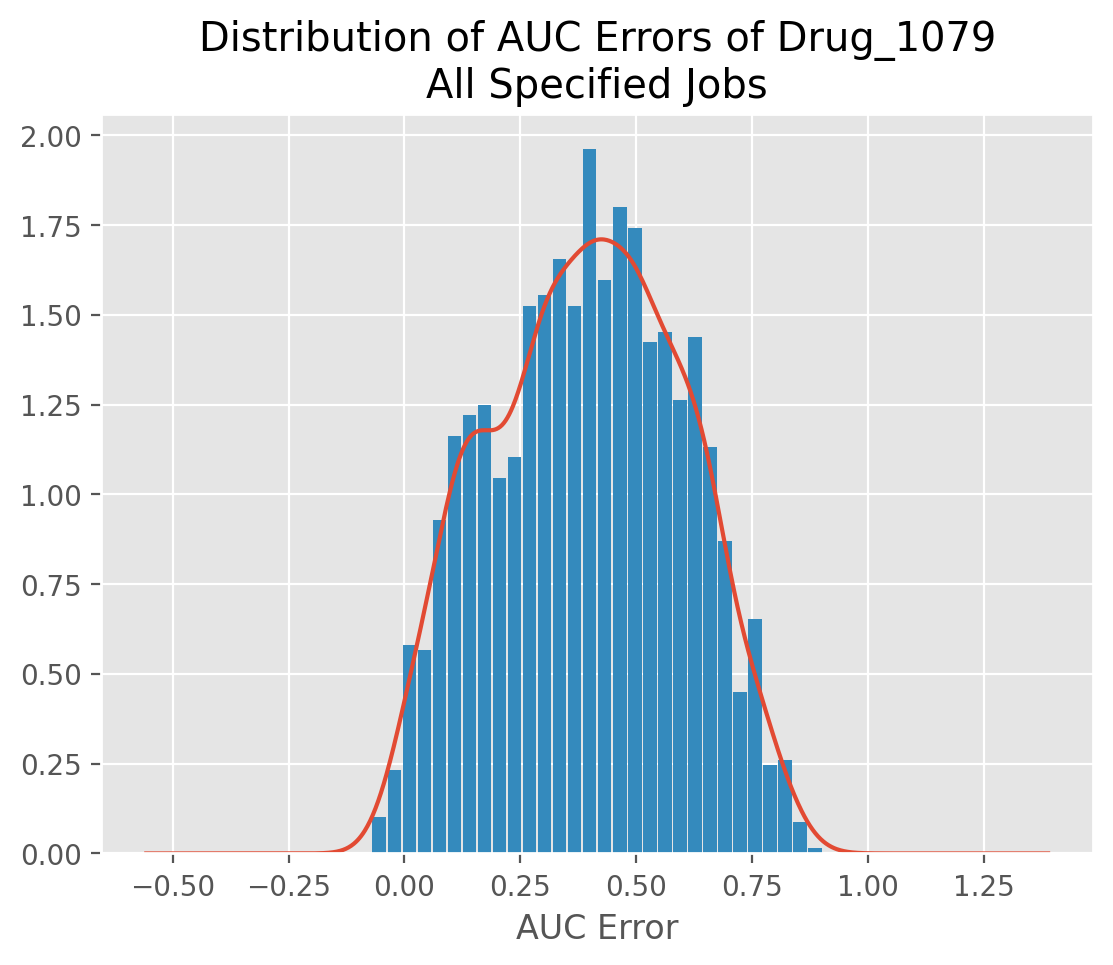

In [36]:
make_distrib_plot("Drug_1079", dict_75)

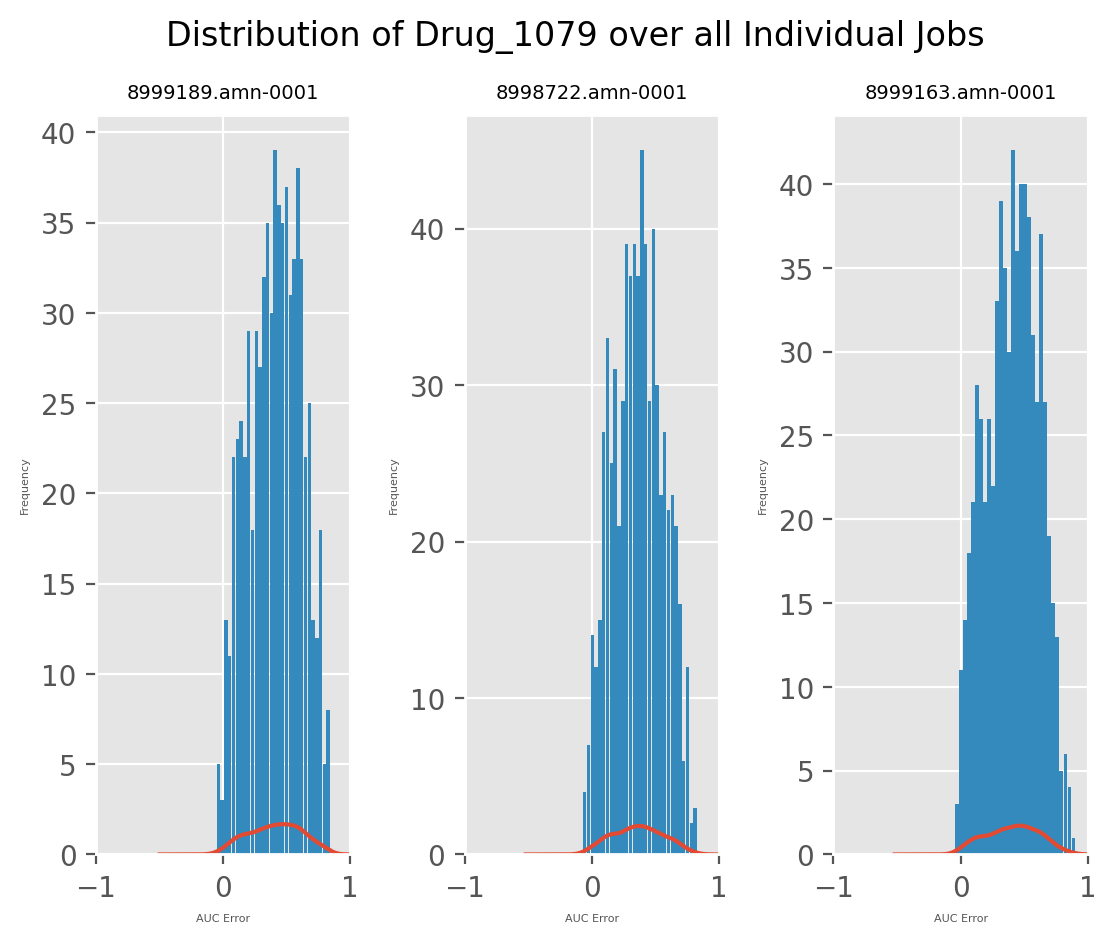

In [37]:
make_multiplot("Drug_1079", path=path, wanted_jobs=jobs_75)

In [38]:
boot_1079 = boostraped_rmse(dict_75["Drug_1079"], 100000)

100%|██████████| 100000/100000 [00:09<00:00, 10060.11it/s]


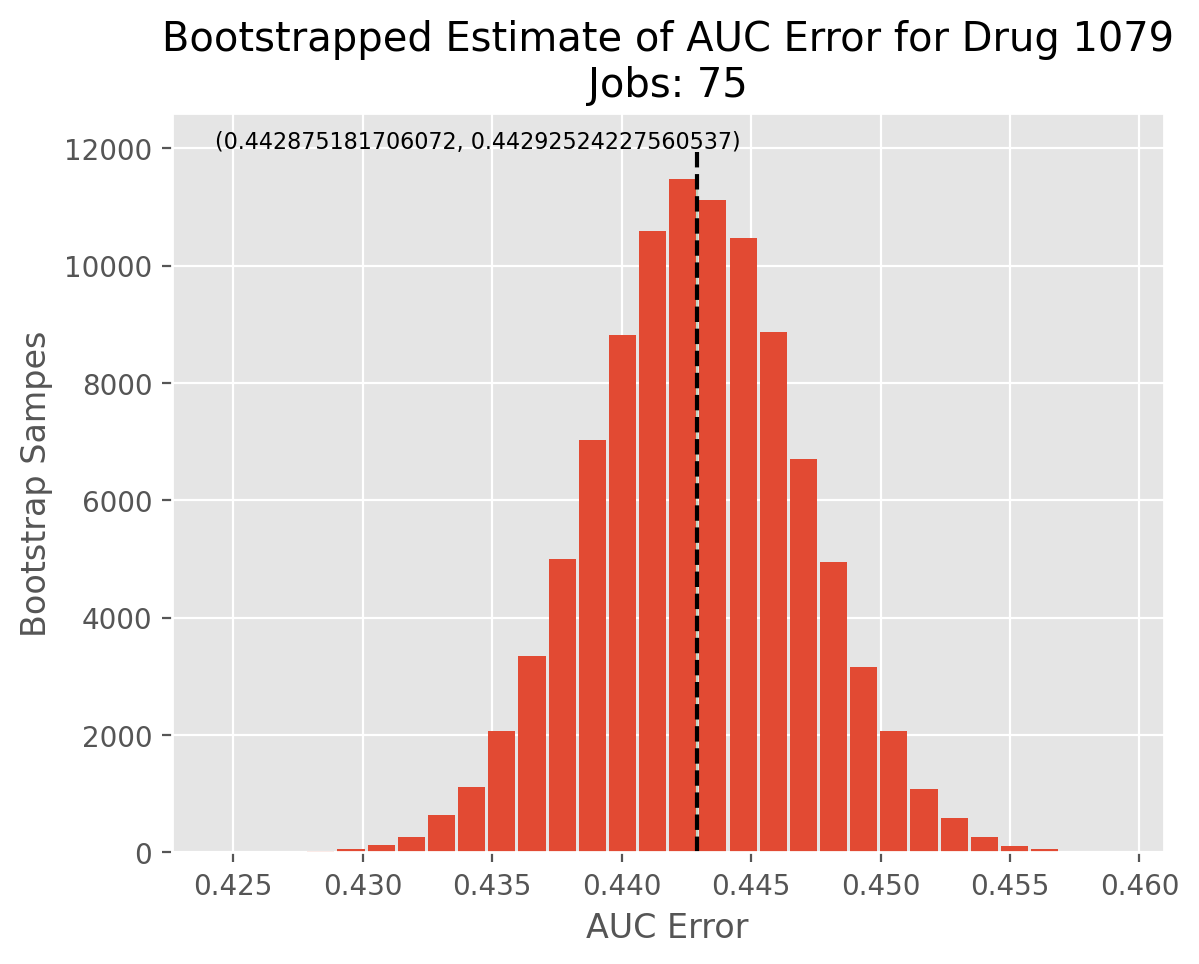

In [39]:
fig, ax = plt.subplots()
confint = st.t.interval(confidence = 0.95, 
                        df = len(boot_1079)-1, 
                        loc = np.mean(boot_1079), 
                        scale = st.sem(boot_1079) )

heights, bins, patches = ax.hist(boot_1079, bins=30, rwidth=0.9)
ax.vlines(x = np.mean(boot_1079), 
          ymin = 0, 
          ymax=12000, 
          colors="black", 
          linestyles="dashed")

ax.set_title(f"Bootstrapped Estimate of AUC Error for Drug 1079\nJobs: 75")
ax.set_ylabel("Bootstrap Sampes")
ax.set_xlabel("AUC Error")
ax.text(x = min(boot_1079), y = 12000, s = confint, size = 8)
ax.fill_betweenx([0, heights.max()],confint[0], confint[1], alpha = 0.1, color = "g")

## T-Testing

In [40]:
dict_75["Drug_988"]

key_list = ["Drug_testing"]
key_list = key_list + list(dict_75.keys())

ttest_data = {key: [] for key in key_list}
for key1 in tqdm.tqdm(dict_75.keys()):
    testing_auc = dict_75[key1]["AUCError"]
    
    for key2 in dict_75.keys():
        if key2 != key1:
            other_auc = dict_75[key2]["AUCError"]
            
            ttest_val = st.ttest_ind(testing_auc, other_auc, equal_var = False)[1]
            
            ttest_data[key2].append(ttest_val)
        else:
            ttest_data[key2].append(np.nan)
    ttest_data["Drug_testing"].append(key1)

# for key, val in ttest_data.items():
#     print(f"{key}: {len(val)}")

ttest_df = pd.DataFrame(ttest_data)

100%|██████████| 144/144 [00:02<00:00, 56.66it/s]


In [41]:
print(ttest_df[ttest_df["Drug_testing"] == "Drug_988"].to_string())
print(ttest_df[ttest_df["Drug_testing"] == "Drug_736"].to_string())
print(ttest_df[ttest_df["Drug_testing"] == "Drug_1079"].to_string())

  Drug_testing  Drug_76  Drug_632  Drug_515  Drug_508  Drug_246  Drug_988  Drug_1064  Drug_1005  Drug_1507  Drug_303  Drug_457      Drug_1062  Drug_620  Drug_1335  Drug_109  Drug_501  Drug_93  Drug_1444  Drug_980  Drug_1102  Drug_13  Drug_563  Drug_1494  Drug_953  Drug_1079  Drug_331  Drug_1391  Drug_146  Drug_1236  Drug_308  Drug_294  Drug_703  Drug_335  Drug_1371  Drug_398  Drug_1434  Drug_31  Drug_946  Drug_1171  Drug_360  Drug_18  Drug_139  Drug_319  Drug_878  Drug_1469  Drug_588  Drug_273  Drug_1560  Drug_288  Drug_1412  Drug_1129  Drug_895  Drug_533  Drug_1253  Drug_284  Drug_520  Drug_1087  Drug_733  Drug_380  Drug_727  Drug_1052  Drug_1356  Drug_1123  Drug_1190  Drug_768  Drug_792  Drug_172  Drug_1165  Drug_1109  Drug_1382  Drug_1327  Drug_1094  Drug_396  Drug_311  Drug_1431  Drug_1088  Drug_635  Drug_864  Drug_601  Drug_8  Drug_1370  Drug_877  Drug_449       Drug_731  Drug_704  Drug_1151  Drug_883  Drug_852  Drug_1448  Drug_1473  Drug_904  Drug_815  Drug_1436  Drug_379  Drug_1

In [42]:
d998_tt = ttest_df[ttest_df["Drug_testing"] == "Drug_988"]
d736_tt = ttest_df[ttest_df["Drug_testing"] == "Drug_736"]
d1079_tt = ttest_df[ttest_df["Drug_testing"] == "Drug_1079"]

d_list = [d998_tt, d736_tt, d1079_tt]

In [43]:
for d in d_list:
    print(d.iloc[0]["Drug_testing"])
    
    for col in d.columns:    
        if col != "Drug_testing":
            
            if d.iloc[0][col] > 0.00000485625: 
                print(f"\t{col}: {d.iloc[0][col]}")
    
    print("#"*80)

Drug_988
	Drug_1079: 0.4402151959771683
	Drug_736: 0.09519768748256309
################################################################################
Drug_736
	Drug_988: 0.09519768748256309
	Drug_1079: 0.4160285483259545
################################################################################
Drug_1079
	Drug_988: 0.4402151959771683
	Drug_736: 0.4160285483259545
################################################################################


In [44]:
dfs_ALL = []

for val in dict_75.values():
    dfs_ALL.append(val)
    
df = pd.concat(dfs_ALL)

In [45]:
df

,AUC,Sample,Drug1,PredictedAUC,AUCError
0,0.9663,ACH-000001,Drug_76,0.9733,0.007003
1,0.9818,ACH-000002,Drug_76,0.9910,0.009242
2,0.9894,ACH-000004,Drug_76,0.9784,-0.010990
3,0.9452,ACH-000006,Drug_76,0.9721,0.026860
4,0.9968,ACH-000007,Drug_76,0.9769,-0.019880
...,...,...,...,...,...
721,0.8177,ACH-001190,Drug_977,0.8422,0.024470
722,0.8307,ACH-001190,Drug_977,0.8795,0.048780
723,0.8895,ACH-001306,Drug_977,0.7050,-0.184500
724,0.7553,ACH-001307,Drug_977,0.7430,-0.012270


In [46]:
# pairwise_tukeyhsd(df["AUCError"], df["Drug1"])
dict_75["Drug_736"]

,AUC,Sample,Drug1,PredictedAUC,AUCError
0,0.4912,ACH-000001,Drug_736,0.9884,0.4972
1,0.2607,ACH-000002,Drug_736,0.9620,0.7013
2,0.6061,ACH-000004,Drug_736,0.9789,0.3728
3,0.4877,ACH-000006,Drug_736,0.9487,0.4610
4,0.4755,ACH-000007,Drug_736,0.9835,0.5080
...,...,...,...,...,...
544,0.4936,ACH-001190,Drug_736,0.9723,0.4787
545,0.7583,ACH-001306,Drug_736,0.9679,0.2096
546,0.5376,ACH-001307,Drug_736,0.9359,0.3983
547,0.6033,ACH-001307,Drug_736,0.9446,0.3413


In [47]:
csv = pairwise_tukeyhsd(df["AUCError"], df["Drug1"], alpha = 0.05).summary().as_csv()
turkey_df = pd.read_csv(StringIO(csv), skiprows = 1)

In [48]:
print(turkey_df[turkey_df["reject"] == "False "].to_string())

         group1     group2   meandiff  p-adj    lower    upper   reject
17     Drug_1005  Drug_1157    0.0046  0.9997  -0.0032   0.0125  False 
82     Drug_1005  Drug_380     0.0036  1.0000  -0.0123   0.0194  False 
94     Drug_1005  Drug_512    -0.0023  1.0000  -0.0153   0.0107  False 
127    Drug_1005  Drug_877     0.0099  0.2958  -0.0014   0.0212  False 
144    Drug_1036  Drug_1062   -0.0023  1.0000  -0.0144   0.0099  False 
276    Drug_1036  Drug_909    -0.0085  1.0000  -0.0244   0.0074  False 
295    Drug_1052  Drug_1109    0.0116  0.1098  -0.0006   0.0237  False 
297    Drug_1052  Drug_1129    0.0104  0.9487  -0.0045   0.0252  False 
298    Drug_1052  Drug_1136    0.0072  0.9999  -0.0056   0.0200  False 
305    Drug_1052  Drug_1200   -0.0085  1.0000  -0.0262   0.0091  False 
320    Drug_1052  Drug_1382   -0.0021  1.0000  -0.0229   0.0188  False 
327    Drug_1052  Drug_1431   -0.0128  0.7107  -0.0293   0.0036  False 
332    Drug_1052  Drug_1448   -0.0090  0.8933  -0.0214   0.0034 

## Normality Testing

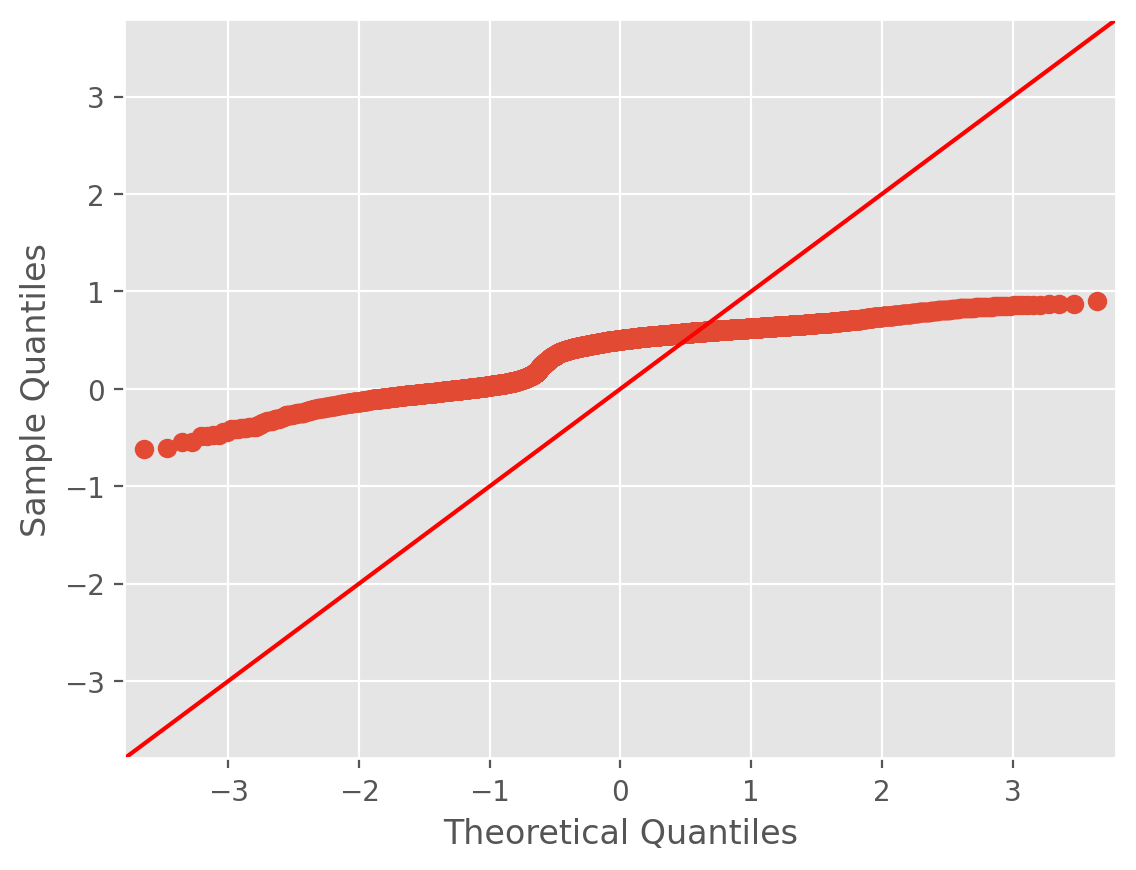

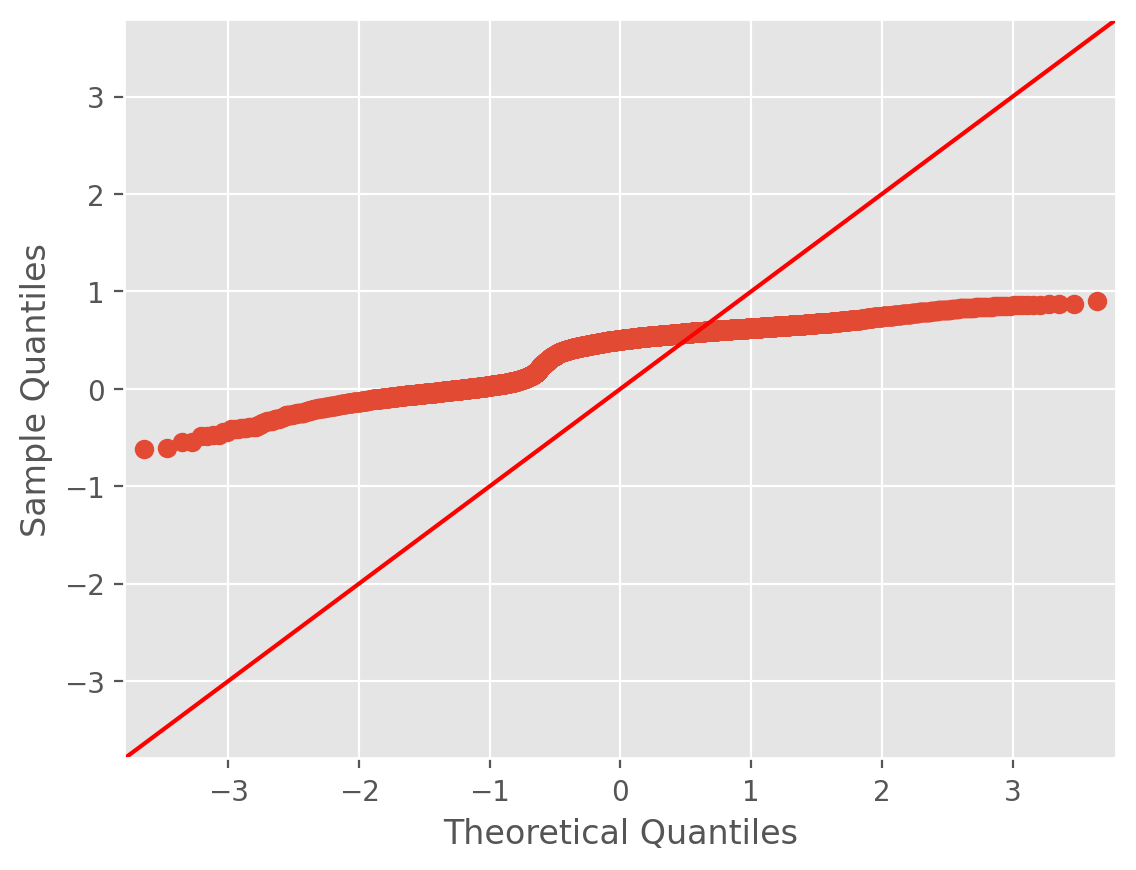

In [49]:
sm.qqplot(dict_75["Drug_988"]["AUCError"], line="45")

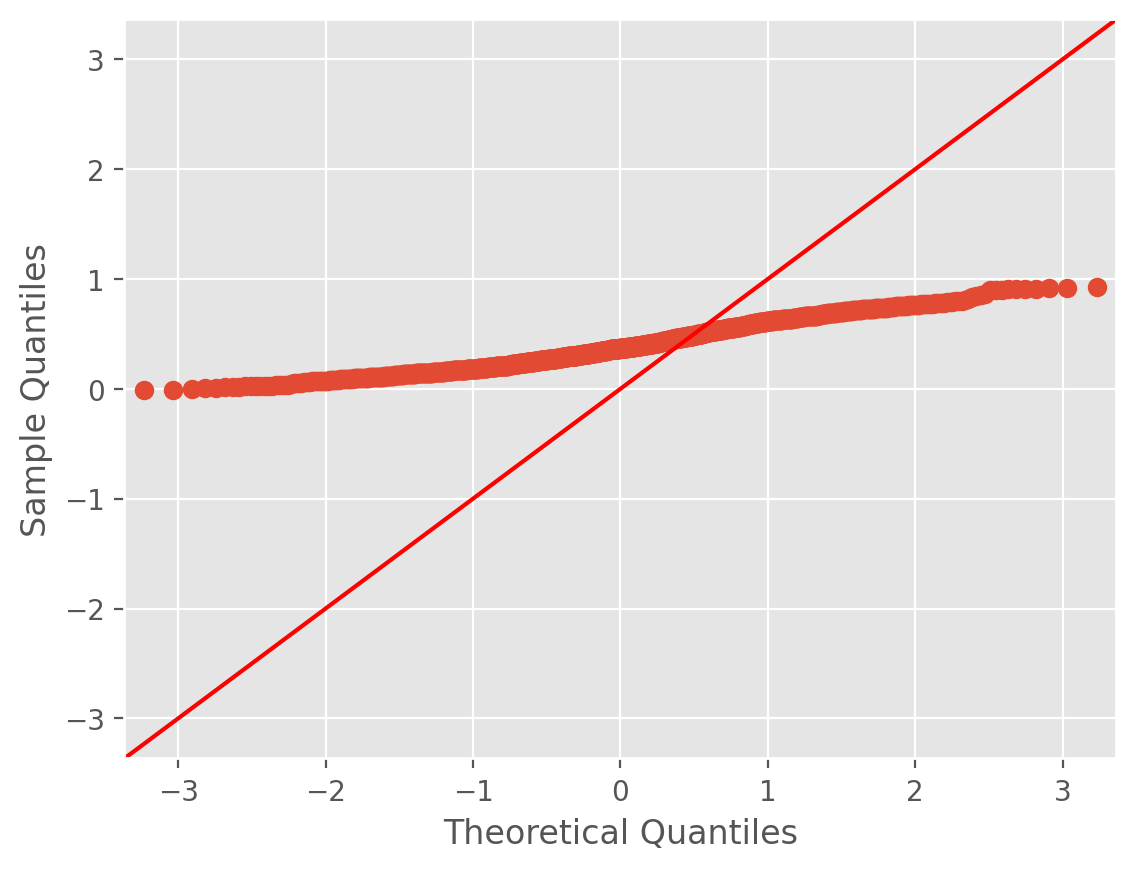

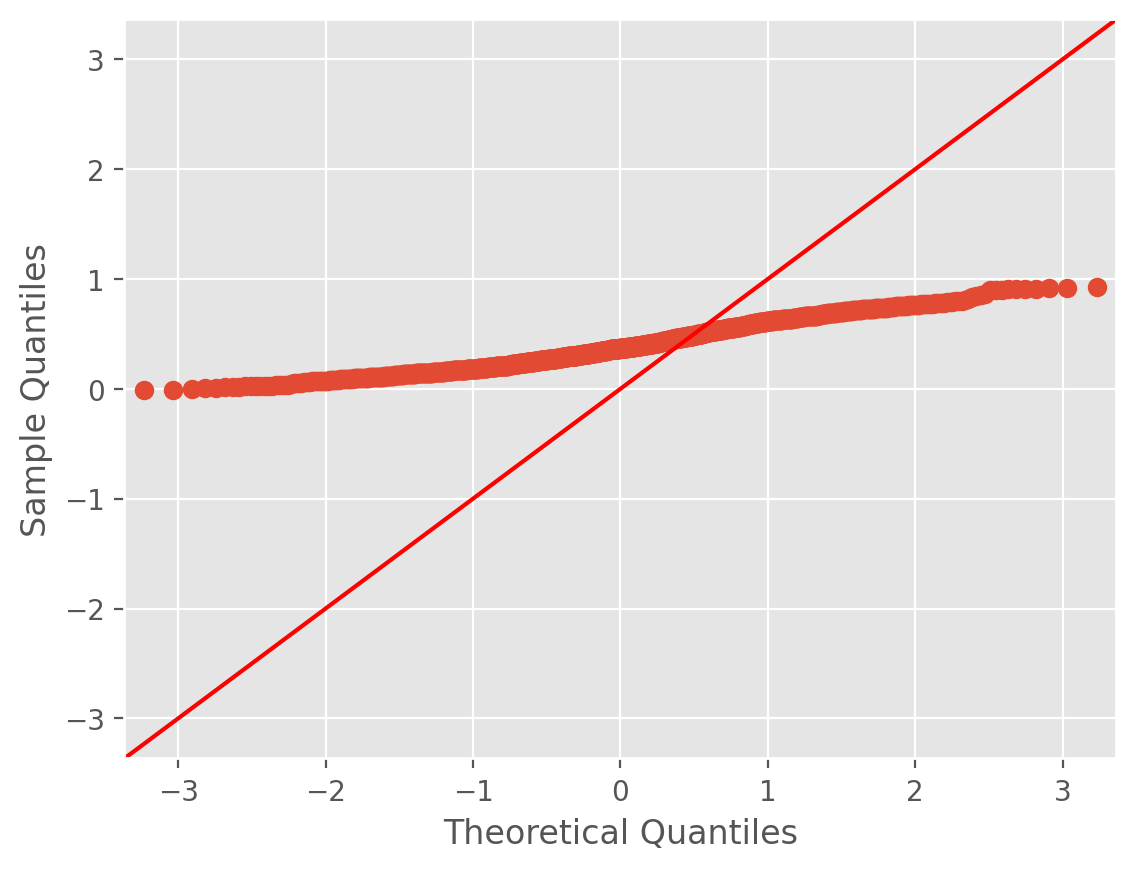

In [50]:
sm.qqplot(dict_75["Drug_736"]["AUCError"], line="45")

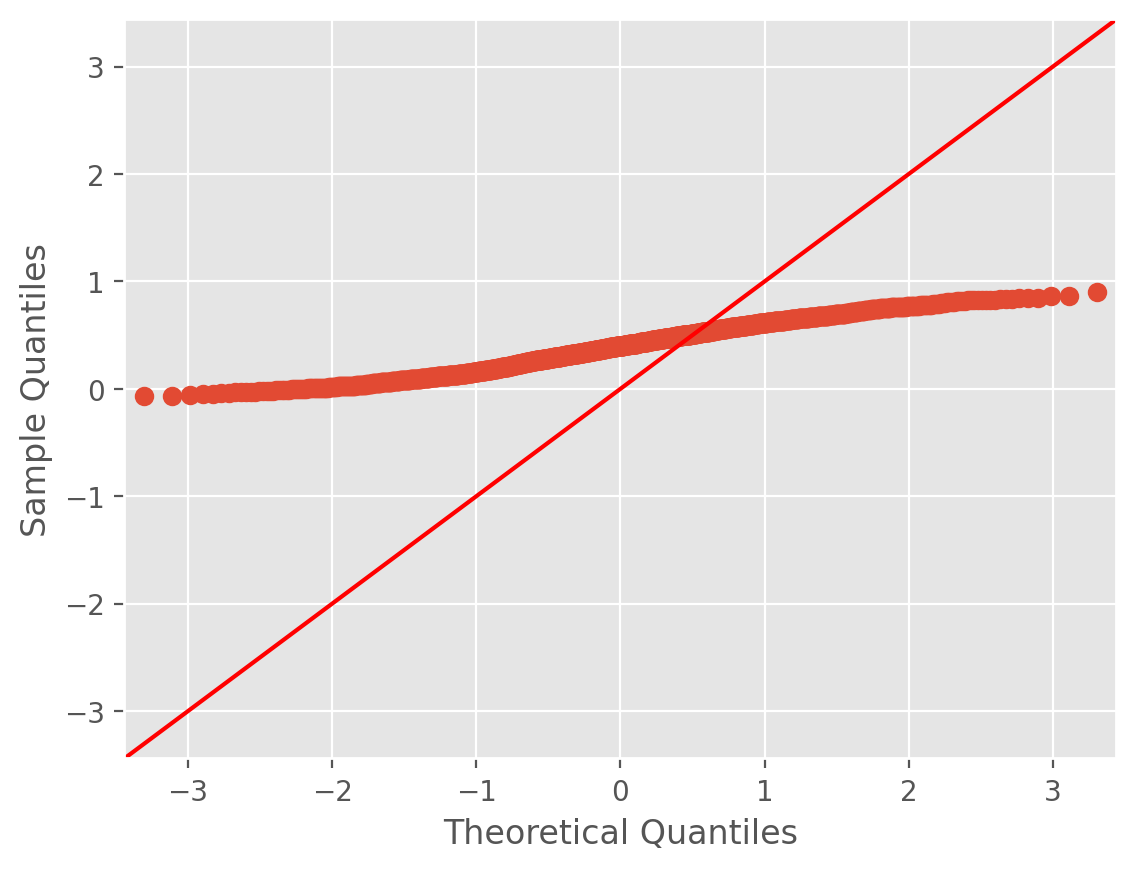

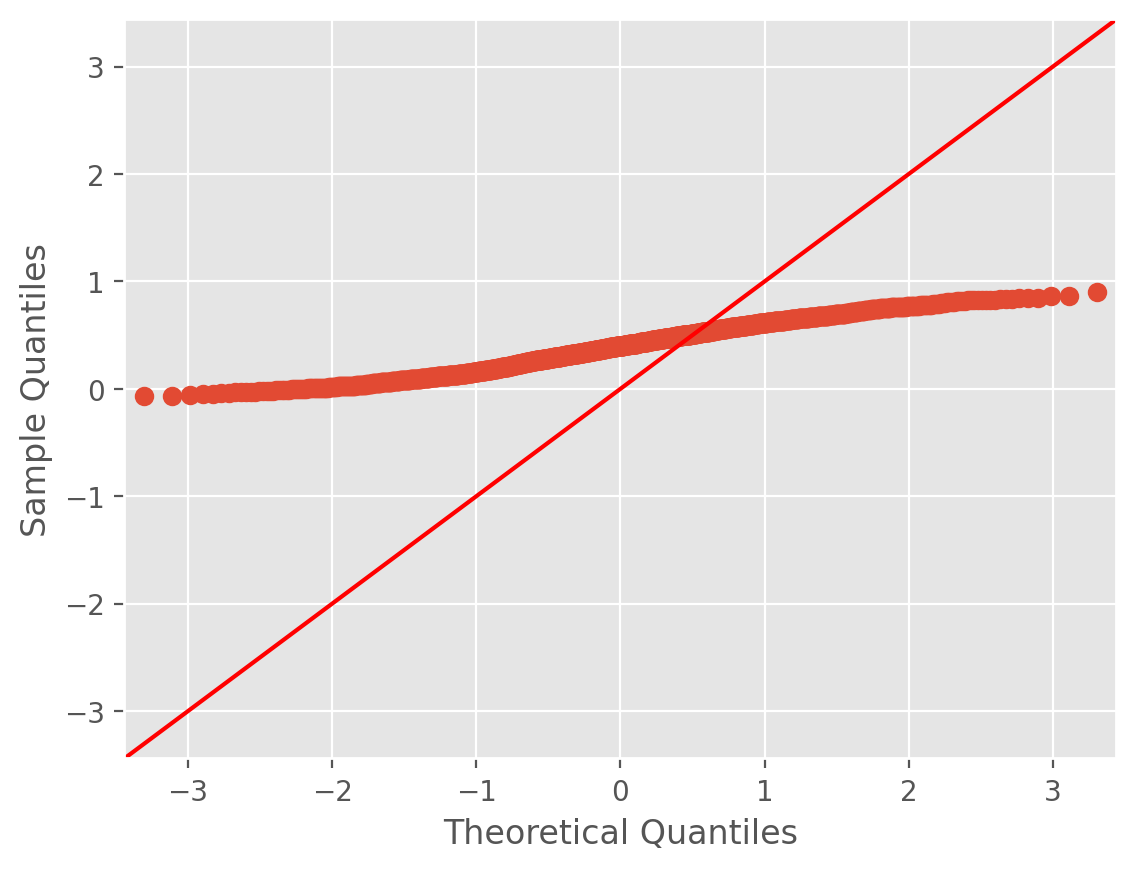

In [51]:
sm.qqplot(dict_75["Drug_1079"]["AUCError"], line="45")

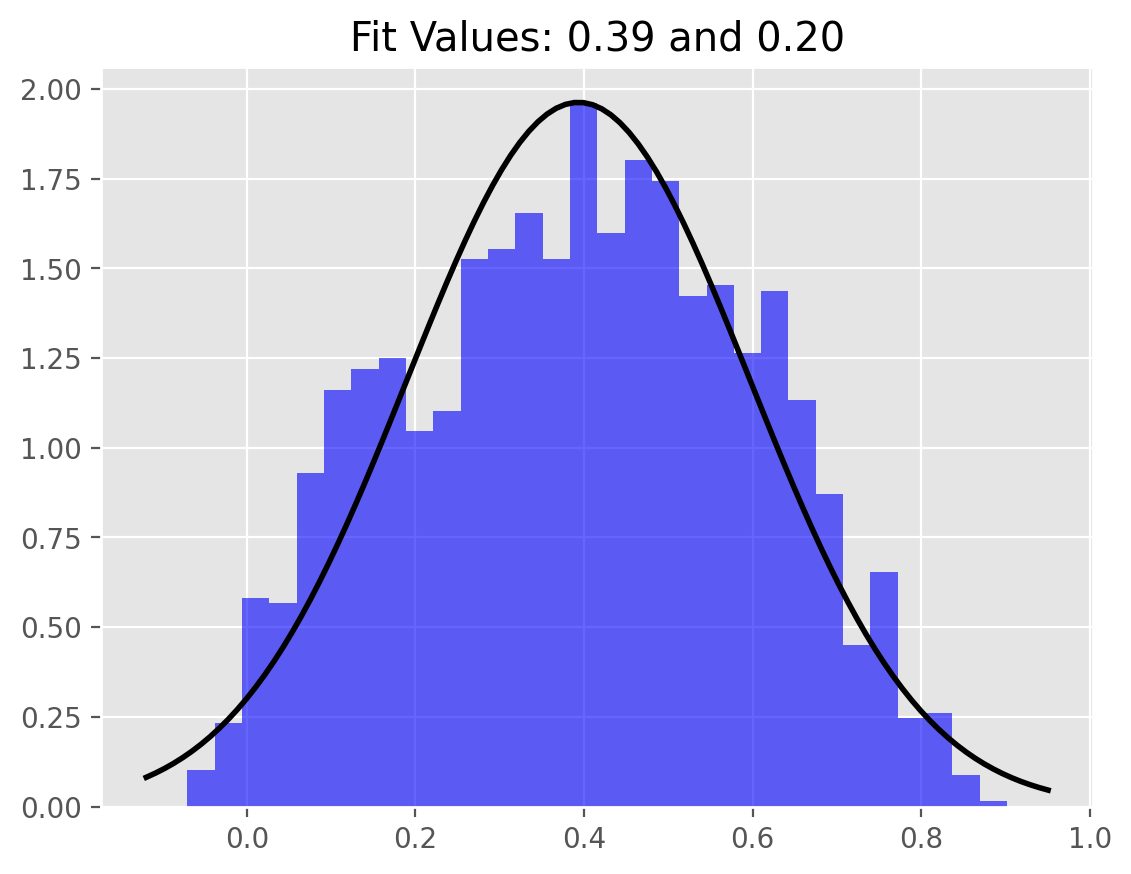

In [52]:
norm_hist(dict_75["Drug_1079"]["AUCError"])

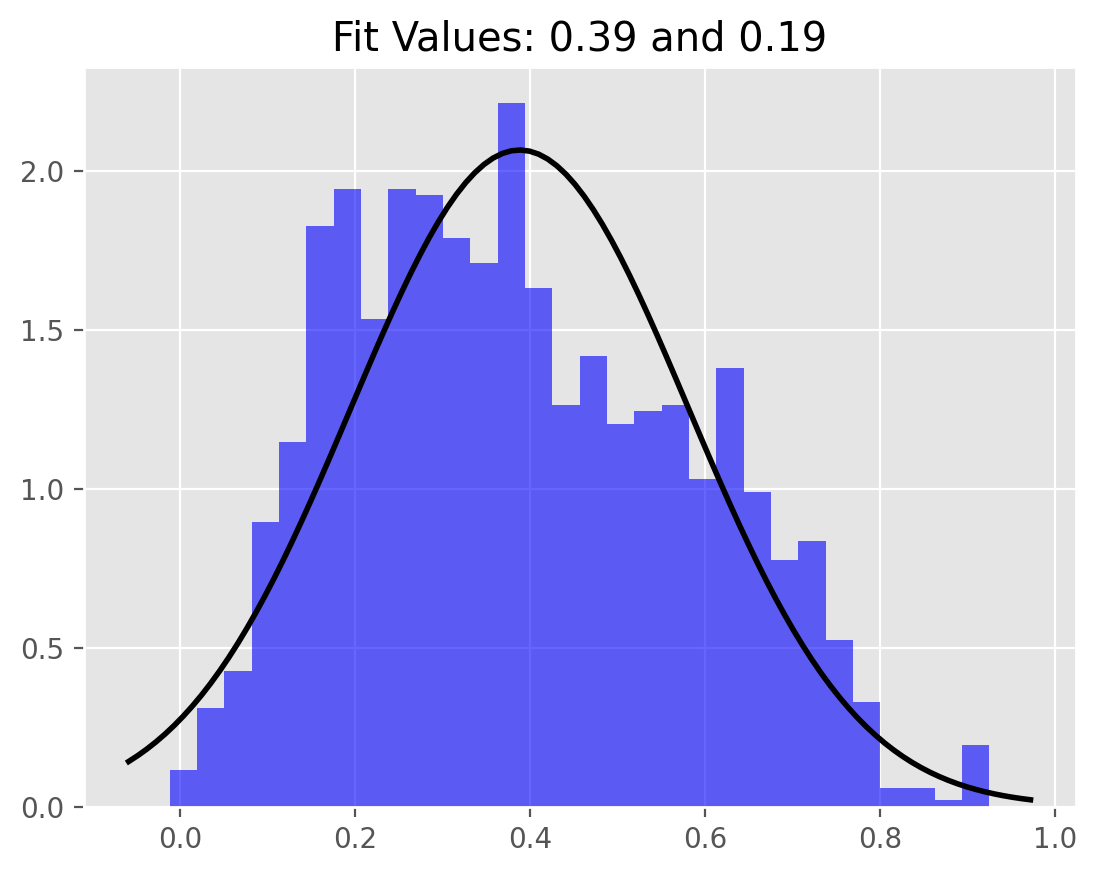

In [53]:
norm_hist(dict_75["Drug_736"]["AUCError"])

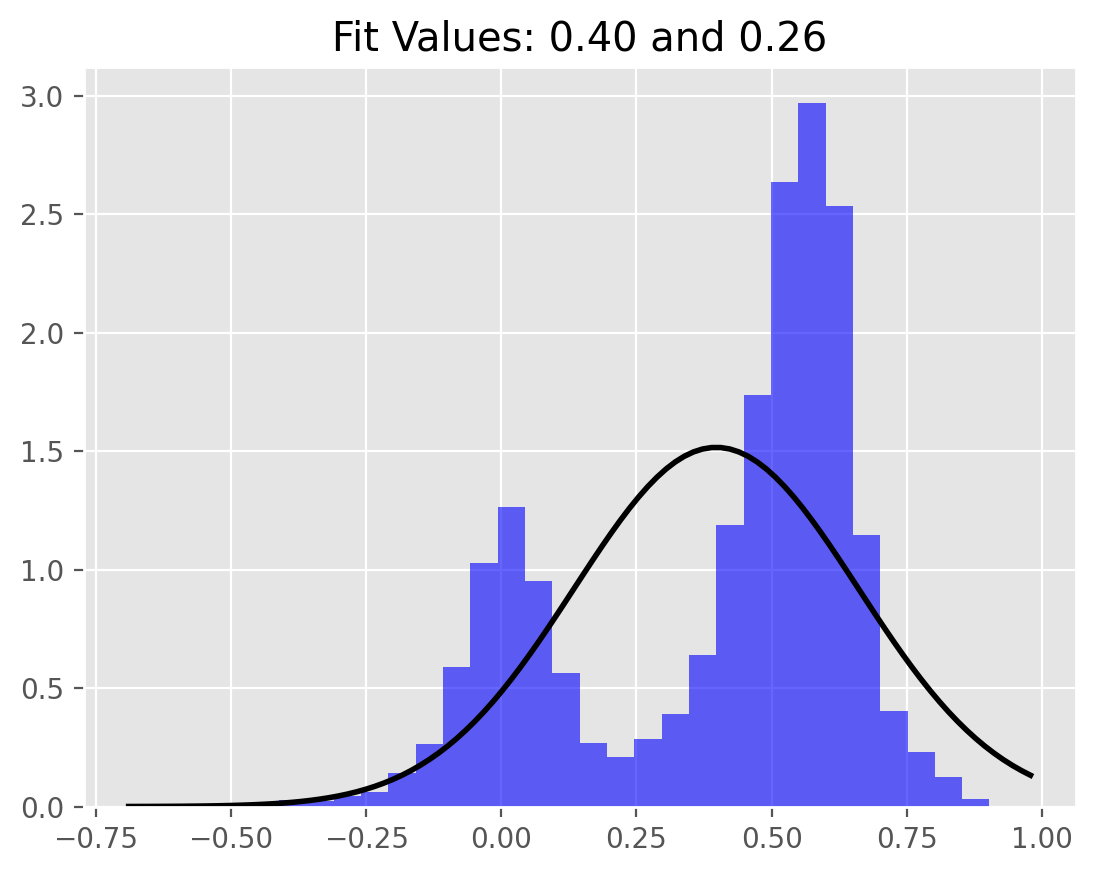

In [54]:
norm_hist(dict_75["Drug_988"]["AUCError"])

In [60]:
d_988, _ = get_all_drug_dfs("Drug_988", path=path, wanted_jobs=jobs_75)

In [61]:
rmses_988 = []
for d in d_988:
    # print(d)
    # print(d["AUC"])
    rmse_curr = mean_squared_error(d["AUC"], d["AUCError"], squared=False)
    rmses_988.append(rmse_curr)
rmses_988

[0.4546706881866192,
 0.3016684217953917,
 0.297577005529419,
 0.29950944812395847]

(array([3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.29757701, 0.30281346, 0.30804992, 0.31328637, 0.31852283,
        0.32375929, 0.32899574, 0.3342322 , 0.33946865, 0.34470511,
        0.34994157, 0.35517802, 0.36041448, 0.36565093, 0.37088739,
        0.37612385, 0.3813603 , 0.38659676, 0.39183322, 0.39706967,
        0.40230613, 0.40754258, 0.41277904, 0.4180155 , 0.42325195,
        0.42848841, 0.43372486, 0.43896132, 0.44419778, 0.44943423,
        0.45467069]),
 <BarContainer object of 30 artists>)

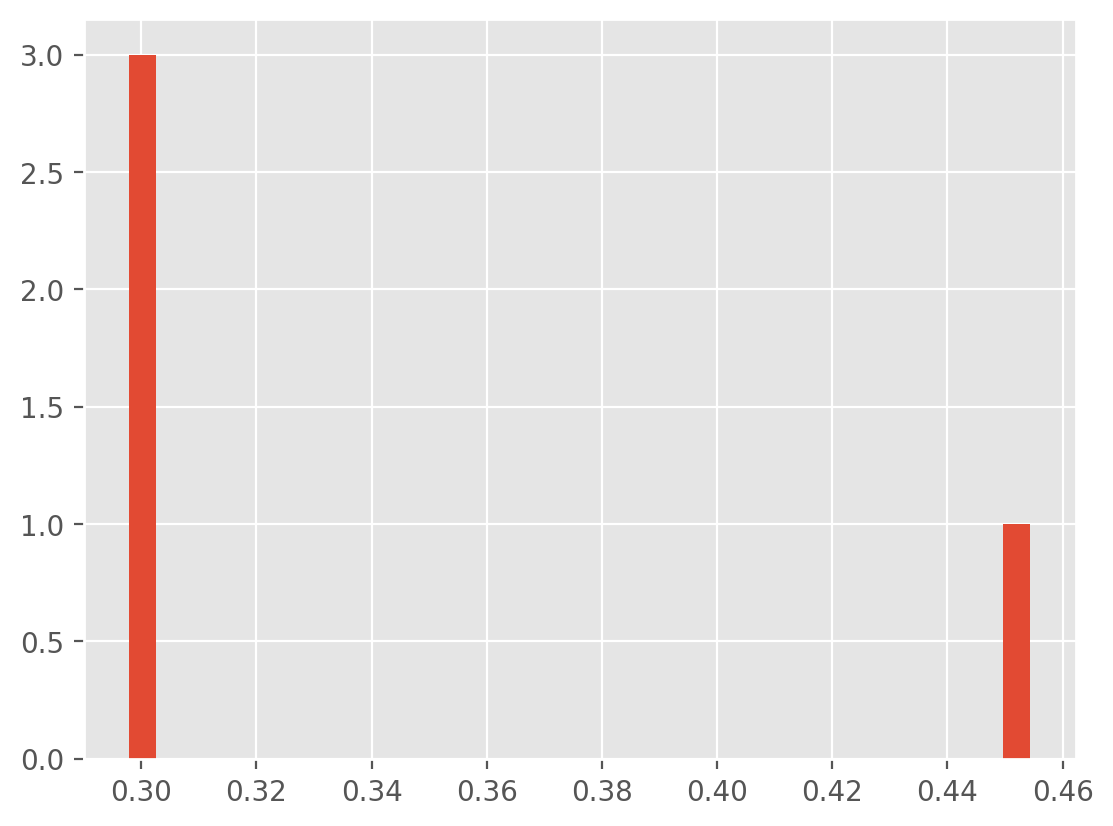

In [62]:
fig, ax = plt.subplots()

ax.hist(rmses_988, bins=30, rwidth=0.9)

In [63]:
d_736, _ = get_all_drug_dfs("Drug_736", path=path, wanted_jobs=jobs_75)

In [64]:
rmses_736 = []
for d in d_736:
    # print(d)
    # print(d["AUC"])
    rmse_curr = mean_squared_error(d["AUC"], d["PredictedAUC"], squared=False)
    rmses_736.append(rmse_curr)
rmses_736

[0.4272759903936199, 0.4304361665164246, 0.4312653902262208]

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]),
 array([0.42727599, 0.42740897, 0.42754195, 0.42767493, 0.42780791,
        0.42794089, 0.42807387, 0.42820685, 0.42833983, 0.42847281,
        0.42860579, 0.42873877, 0.42887175, 0.42900473, 0.42913771,
        0.42927069, 0.42940367, 0.42953665, 0.42966963, 0.42980261,
        0.42993559, 0.43006857, 0.43020155, 0.43033453, 0.43046751,
        0.43060049, 0.43073347, 0.43086645, 0.43099943, 0.43113241,
        0.43126539]),
 <BarContainer object of 30 artists>)

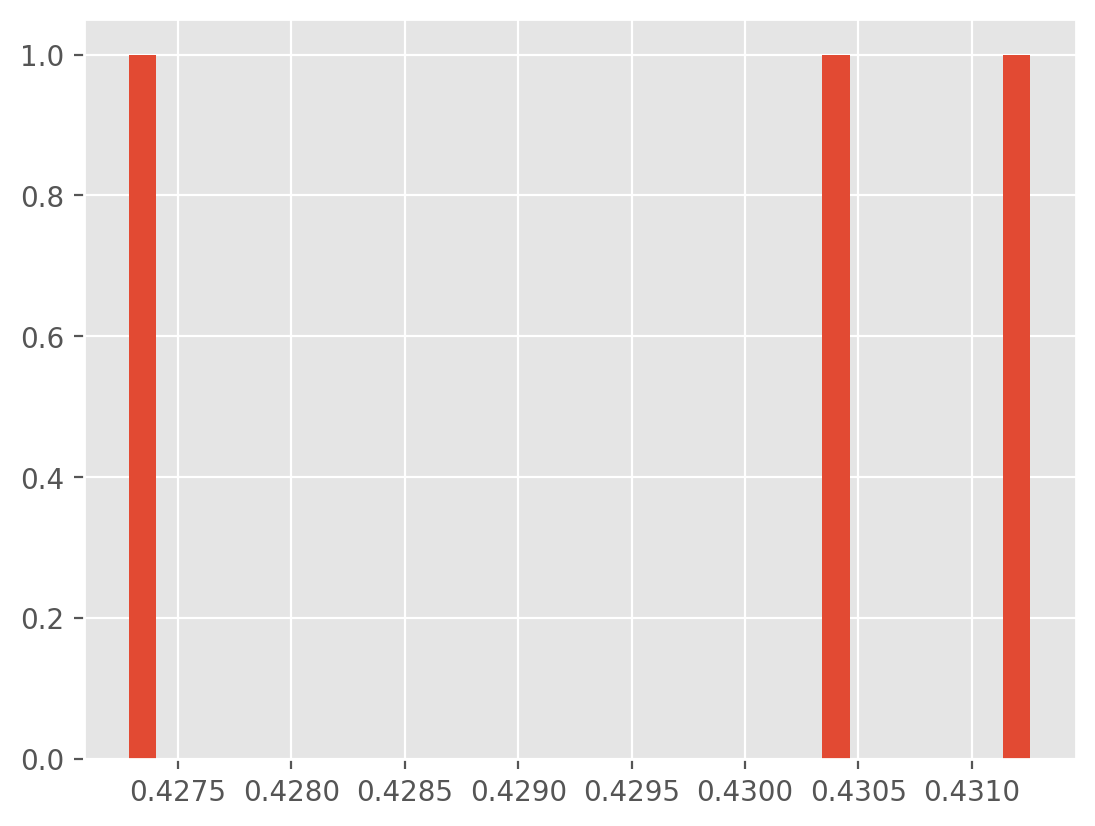

In [65]:
fig, ax = plt.subplots()

ax.hist(rmses_736, bins=30, rwidth=0.9)

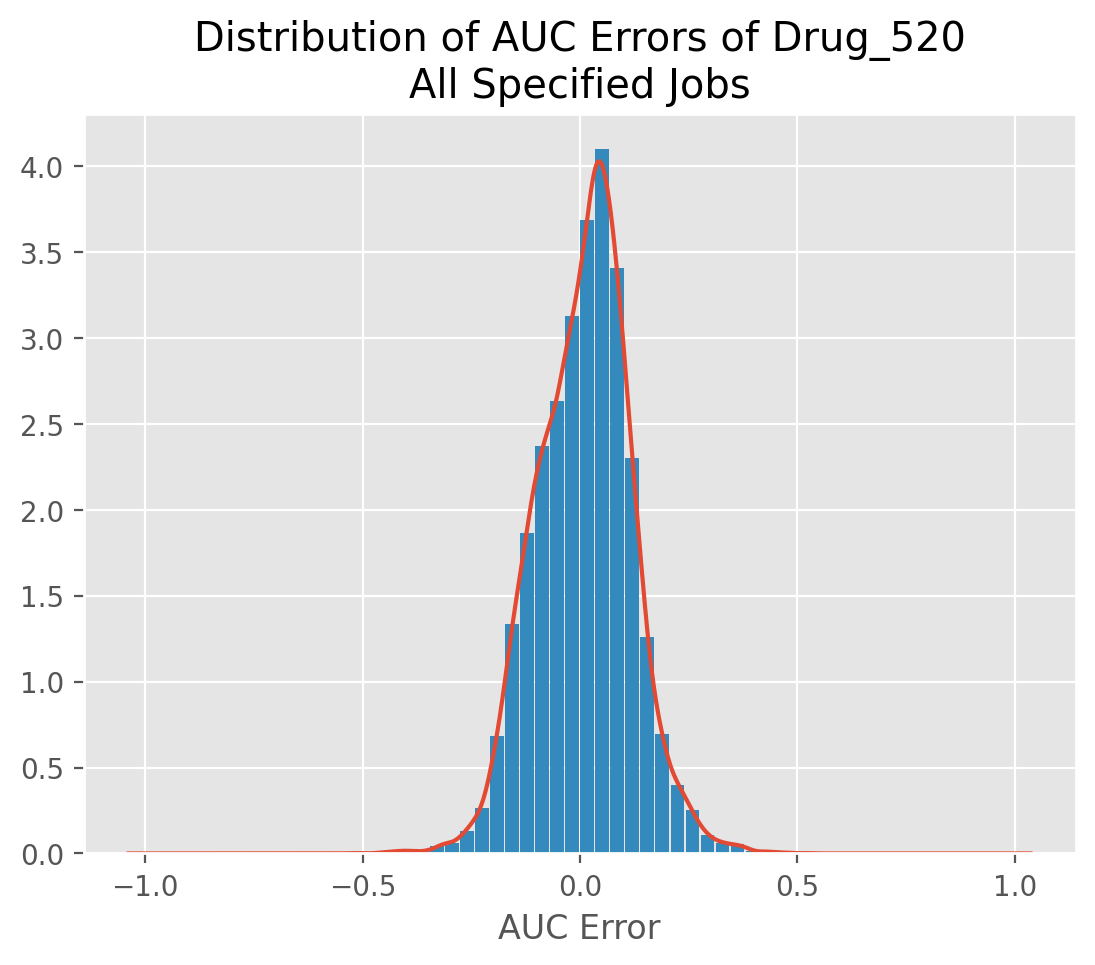

In [69]:
d_520 = dict_75["Drug_520"]

make_distrib_plot("Drug_520", dict_75)